# Telecom Churn Case Study
## Problem Statement
### Business problem overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

Understanding and defining churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.

### Definitions of churn
There are various ways to define churn, such as:

Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, you will use the usage-based definition to define churn.

### High-value churn
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

### Understanding customer behaviour during churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

In [1]:
# Importing packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#setting format options to allow proper data display
pd.set_option('display.max.rows',250)
pd.set_option('display.max.columns',250)
pd.set_option('float_format', '{:.2f}'.format)

In [3]:
#importing data set
df = pd.read_csv('telecom_churn_data.csv')

In [4]:
df.shape

(99999, 226)

In [5]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,Na

## Data Dictionary

Acronyms    	Descriptions
MOBILE_NUMBER	Customer phone number
CIRCLE_ID	Telecom circle area to which the customer belongs to
LOC	Local calls - within same telecom circle
STD	STD calls - outside the calling circle
IC	Incoming calls
OG	Outgoing calls
T2T	Operator T to T, i.e. within same operator (mobile to mobile)
T2M    	Operator T to other operator mobile
T2O    	Operator T to other operator fixed line
T2F    	Operator T to fixed lines of T
T2C    	Operator T to it’s own call center
ARPU    	Average revenue per user
MOU    	Minutes of usage - voice calls
AON    	Age on network - number of days the customer is using the operator T network
ONNET   	All kind of calls within the same operator network
OFFNET    	All kind of calls outside the operator T network
ROAM	Indicates that customer is in roaming zone during the call
SPL   	Special calls
ISD    	ISD calls
RECH    	Recharge
NUM    	Number
AMT    	Amount in local currency
MAX    	Maximum
DATA    	Mobile internet
3G    	3G network
AV    	Average
VOL    	Mobile internet usage volume (in MB)
2G    	2G network
PCK    	Prepaid service schemes called - PACKS
NIGHT    	Scheme to use during specific night hours only
MONTHLY    	Service schemes with validity equivalent to a month
SACHET   	Service schemes with validity smaller than a month
*.6    	KPI for the month of June
*.7    	KPI for the month of July
*.8    	KPI for the month of August
*.9    	KPI for the month of September
FB_USER	Service scheme to avail services of Facebook and similar social networking sites
VBC    	Volume based cost - when no specific scheme is not purchased and paid as per usage

## Understanding the Data

In [6]:
# Checking the informations regarding the dataset
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,99999.00,7001207270.39,695669.39,7000000074.00,7000606232.50,7001204632.00,7001812030.50,7002410905.00
circle_id,99999.00,109.00,0.00,109.00,109.00,109.00,109.00,109.00
loc_og_t2o_mou,98981.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std_og_t2o_mou,98981.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loc_ic_t2o_mou,98981.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
arpu_6,99999.00,282.99,328.44,-2258.71,93.41,197.70,371.06,27731.09
arpu_7,99999.00,278.54,338.16,-2014.05,86.98,191.64,365.34,35145.83
arpu_8,99999.00,279.15,344.47,-945.81,84.13,192.08,369.37,33543.62
arpu_9,99999.00,261.65,342.00,-1899.51,62.69,176.85,353.47,38805.62
onnet_mou_6,96062.00,132.40,297.21,0.00,7.38,34.31,118.74,7376.71


There are a lot of columns where the data is either highly skewed or where the data is the same value throughout
Lets see further for some columns which we can drop

In [8]:
# lets check the columns with same values and drop such columns
same_val_col=[]
for i in df.columns:
    if df[i].nunique() == 1:
        same_val_col.append(i)
    else:
        pass

df.drop(same_val_col, axis=1, inplace = True)
print("\n The following Columns are dropped from the dataset as their unique value is 1, in short no variance for modelling \n",
      same_val_col)


 The following Columns are dropped from the dataset as their unique value is 1, in short no variance for modelling 
 ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


In [9]:
#Checking for null values
((df.isnull().sum()/df.shape[0])*100).round(2).sort_values(ascending=False)

max_rech_data_6            74.85
fb_user_6                  74.85
count_rech_3g_6            74.85
count_rech_2g_6            74.85
night_pck_user_6           74.85
arpu_3g_6                  74.85
total_rech_data_6          74.85
av_rech_amt_data_6         74.85
arpu_2g_6                  74.85
date_of_last_rech_data_6   74.85
arpu_3g_7                  74.43
night_pck_user_7           74.43
total_rech_data_7          74.43
date_of_last_rech_data_7   74.43
av_rech_amt_data_7         74.43
max_rech_data_7            74.43
fb_user_7                  74.43
count_rech_3g_7            74.43
arpu_2g_7                  74.43
count_rech_2g_7            74.43
count_rech_3g_9            74.08
date_of_last_rech_data_9   74.08
count_rech_2g_9            74.08
fb_user_9                  74.08
total_rech_data_9          74.08
max_rech_data_9            74.08
night_pck_user_9           74.08
arpu_2g_9                  74.08
av_rech_amt_data_9         74.08
arpu_3g_9                  74.08
arpu_3g_8 

A lot of columns have more than 30% of null values

As we can see that the columns with datetime values represented as object, they can be converted into datetime format



In [10]:
# selecting all the columns with datetime format
date_col= df.select_dtypes(include=['object'])
print("\nThese are the columns available with datetime format represented as object\n",date_col.columns)

# Converting the selected columns to datetime format
for i in date_col.columns:
    df[i] = pd.to_datetime(df[i])

# Current dimension of the dataset
df.shape


These are the columns available with datetime format represented as object
 Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')


(99999, 210)

In [11]:
# confirming the conversion of dtype
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 210 columns):
 #    Column                    Dtype         
---   ------                    -----         
 0    mobile_number             int64         
 1    arpu_6                    float64       
 2    arpu_7                    float64       
 3    arpu_8                    float64       
 4    arpu_9                    float64       
 5    onnet_mou_6               float64       
 6    onnet_mou_7               float64       
 7    onnet_mou_8               float64       
 8    onnet_mou_9               float64       
 9    offnet_mou_6              float64       
 10   offnet_mou_7              float64       
 11   offnet_mou_8              float64       
 12   offnet_mou_9              float64       
 13   roam_ic_mou_6             float64       
 14   roam_ic_mou_7             float64       
 15   roam_ic_mou_8             float64       
 16   roam_ic_mou_9             float64     

## Missing Value Treatment

first we will try and find redundant columns to drop the data

In [12]:
((df.isnull().sum()/df.shape[0])*100).round(2).sort_values(ascending=False)

max_rech_data_6            74.85
fb_user_6                  74.85
count_rech_3g_6            74.85
count_rech_2g_6            74.85
night_pck_user_6           74.85
arpu_3g_6                  74.85
total_rech_data_6          74.85
av_rech_amt_data_6         74.85
arpu_2g_6                  74.85
date_of_last_rech_data_6   74.85
arpu_3g_7                  74.43
night_pck_user_7           74.43
total_rech_data_7          74.43
date_of_last_rech_data_7   74.43
av_rech_amt_data_7         74.43
max_rech_data_7            74.43
fb_user_7                  74.43
count_rech_3g_7            74.43
arpu_2g_7                  74.43
count_rech_2g_7            74.43
count_rech_3g_9            74.08
date_of_last_rech_data_9   74.08
count_rech_2g_9            74.08
fb_user_9                  74.08
total_rech_data_9          74.08
max_rech_data_9            74.08
night_pck_user_9           74.08
arpu_2g_9                  74.08
av_rech_amt_data_9         74.08
arpu_3g_9                  74.08
arpu_3g_8 

The column fb_user_* and night_pck_user_* for each month from 6 to 9 respectively has a missing values above 50% and does not seem to add any information to understand the data. Hence we can drop these columns for further analysis.

In [13]:
df.drop(['fb_user_6','fb_user_7','fb_user_8','fb_user_9',\
                  'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9'],\
                  axis=1, inplace=True)

In [14]:
#looking at columns with _6 months of data around recharges
df[['max_rech_data_6', 'count_rech_3g_6', 'count_rech_2g_6', 'arpu_3g_6', 'total_rech_data_6', 'av_rech_amt_data_6',\
   'arpu_2g_6', 'date_of_last_rech_data_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6']].head(50)

,max_rech_data_6,count_rech_3g_6,count_rech_2g_6,arpu_3g_6,total_rech_data_6,av_rech_amt_data_6,arpu_2g_6,date_of_last_rech_data_6,total_rech_num_6,total_rech_amt_6,max_rech_amt_6
0,252.00,1.00,0.00,212.17,1.00,252.00,212.17,2014-06-21,4,362,252
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4,74,44
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,5,168,86
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,10,230,60
4,56.00,0.00,1.00,0.00,1.00,56.00,0.00,2014-06-04,5,196,56
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2,120,120
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,15,499,90
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,5,1580,1580
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,19,437,90
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,4,220,110


we can see, total_rech_data_6 is summation of count_rech_3g_6 and count_rech_2g_6
the same can be asssumed for total_rech_data_7 and _8 and _9 

In [15]:
# thus dropping columns with count_rech_2g_* and count_rech_3g_*
df.drop(['count_rech_2g_6','count_rech_3g_6','count_rech_2g_7','count_rech_3g_7','count_rech_2g_8','count_rech_3g_8',\
         'count_rech_2g_9','count_rech_3g_9'],axis=1, inplace=True)

In [16]:
df.shape

(99999, 194)

In [17]:
#ensuring if all columns (av_rech_amt_data, total_rech_data and date_of_last_rech_data) have null values together

In [18]:
df.loc[(df.av_rech_amt_data_6.isna()) & (df.total_rech_data_6.isna())\
       & (~df.date_of_last_rech_data_6.isna())][['total_rech_data_6','av_rech_amt_data_6',\
                                                 'date_of_last_rech_data_6']].head(50)


,total_rech_data_6,av_rech_amt_data_6,date_of_last_rech_data_6


In [19]:
df.loc[(df.av_rech_amt_data_6.isna()) & (~df.total_rech_data_6.isna())\
       & (df.date_of_last_rech_data_6.isna())][['total_rech_data_6','av_rech_amt_data_6',\
                                                'date_of_last_rech_data_6']].head(50)


,total_rech_data_6,av_rech_amt_data_6,date_of_last_rech_data_6


In [20]:
df.loc[(~df.av_rech_amt_data_6.isna()) & (df.total_rech_data_6.isna())\
       & (df.date_of_last_rech_data_6.isna())][['av_rech_amt_data_6','total_rech_data_6',\
                                                'date_of_last_rech_data_6']].head(50)


,av_rech_amt_data_6,total_rech_data_6,date_of_last_rech_data_6


thus from above we can confirm that max_rech_data_6, total_rech_data_6 and date_last_rech_data_6 are null when anyone is null, the same can be assumed for _7 _8 and _9 months

In [21]:
#Thus filling null values with 0
df[['av_rech_amt_data_6', 'total_rech_data_6', 'av_rech_amt_data_7', 'total_rech_data_7', 'av_rech_amt_data_8',\
    'total_rech_data_8','av_rech_amt_data_9',\
    'total_rech_data_9']] = df[['av_rech_amt_data_6', 'total_rech_data_6', 'av_rech_amt_data_7', 'total_rech_data_7',\
                                'av_rech_amt_data_8', 'total_rech_data_8','av_rech_amt_data_9',\
                                'total_rech_data_9']].fillna(0)


In [22]:
# validating pattern in arpu_2g and arpu_3g with avg_rech_amt_data
df[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].head(50)

,arpu_3g_6,arpu_2g_6,av_rech_amt_data_6
0,212.17,212.17,252.00
1,NaN,NaN,0.00
2,NaN,NaN,0.00
3,NaN,NaN,0.00
4,0.00,0.00,56.00
5,NaN,NaN,0.00
6,NaN,NaN,0.00
7,NaN,NaN,0.00
8,NaN,NaN,0.00
9,NaN,NaN,0.00


Since there is no summation or average pattern we should check for correlation to omit multi colinearity

In [23]:
# identifying correlation:
print('_6')
print(df[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].corr())

print('\n _7')
print(df[['arpu_3g_7','arpu_2g_7','av_rech_amt_data_7']].corr())

print('\n _8')
print(df[['arpu_3g_8','arpu_2g_8','av_rech_amt_data_8']].corr())

print('\n _9')
print(df[['arpu_3g_9','arpu_2g_9','av_rech_amt_data_9']].corr())

_6
                    arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
arpu_3g_6                1.00       0.93                0.81
arpu_2g_6                0.93       1.00                0.83
av_rech_amt_data_6       0.81       0.83                1.00

 _7
                    arpu_3g_7  arpu_2g_7  av_rech_amt_data_7
arpu_3g_7                1.00       0.93                0.80
arpu_2g_7                0.93       1.00                0.82
av_rech_amt_data_7       0.80       0.82                1.00

 _8
                    arpu_3g_8  arpu_2g_8  av_rech_amt_data_8
arpu_3g_8                1.00       0.92                0.79
arpu_2g_8                0.92       1.00                0.81
av_rech_amt_data_8       0.79       0.81                1.00

 _9
                    arpu_3g_9  arpu_2g_9  av_rech_amt_data_9
arpu_3g_9                1.00       0.85                0.72
arpu_2g_9                0.85       1.00                0.82
av_rech_amt_data_9       0.72       0.82                1.00


arpu_2g_* and arpu_3g_* are highly correlated with av_rech_amt_data_*, thus we can drop the former

In [24]:
# Dropping the columns 'arpu_3g_*'&'arpu_2g_*'
df.drop(['arpu_3g_6','arpu_2g_6','arpu_3g_7','arpu_2g_7','arpu_3g_8','arpu_2g_8','arpu_3g_9','arpu_2g_9'],axis=1, inplace=True)


In [25]:
df.shape

(99999, 186)

In [26]:
# Checkng the overall missing values in the dataset
((df.isnull().sum()/df.shape[0])*100).round(2).sort_values(ascending=False)

max_rech_data_6            74.85
date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
max_rech_data_7            74.43
max_rech_data_9            74.08
date_of_last_rech_data_9   74.08
max_rech_data_8            73.66
date_of_last_rech_data_8   73.66
loc_ic_t2m_mou_9            7.75
std_og_t2t_mou_9            7.75
std_og_t2m_mou_9            7.75
std_og_t2f_mou_9            7.75
std_og_mou_9                7.75
isd_og_mou_9                7.75
spl_og_mou_9                7.75
og_others_9                 7.75
loc_og_mou_9                7.75
std_ic_t2t_mou_9            7.75
loc_ic_t2f_mou_9            7.75
loc_ic_mou_9                7.75
loc_og_t2f_mou_9            7.75
std_ic_t2m_mou_9            7.75
std_ic_t2f_mou_9            7.75
std_ic_mou_9                7.75
spl_ic_mou_9                7.75
isd_ic_mou_9                7.75
ic_others_9                 7.75
loc_og_t2c_mou_9            7.75
loc_ic_t2t_mou_9            7.75
loc_og_t2t_mou_9            7.75
loc_og_t2m

thus number of columns with more than 30% of missing data have been reduced, further we can drop date_of_last_rech_data_* as it provides no use for our analysis

In [27]:
df.drop(["date_of_last_rech_data_6","date_of_last_rech_data_7",\
         "date_of_last_rech_data_8","date_of_last_rech_data_9",\
         "date_of_last_rech_6","date_of_last_rech_7",\
         "date_of_last_rech_8","date_of_last_rech_9"], axis=1, inplace=True)

df.shape

(99999, 178)

In [28]:
#filling na for max_rech_data_* as their values are also 0 when total_rech__dat_* is 0
df[['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',\
    'max_rech_data_9']] = df[['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',\
                              'max_rech_data_9']].fillna(0)


In [29]:
#Checking for null values
((df.isnull().sum()/df.shape[0])*100).round(2).sort_values(ascending=False)

std_og_t2t_mou_9     7.75
roam_ic_mou_9        7.75
loc_ic_mou_9         7.75
loc_og_t2c_mou_9     7.75
std_og_t2m_mou_9     7.75
loc_og_t2f_mou_9     7.75
std_og_t2f_mou_9     7.75
std_og_mou_9         7.75
loc_og_t2m_mou_9     7.75
std_ic_t2f_mou_9     7.75
spl_ic_mou_9         7.75
loc_og_t2t_mou_9     7.75
isd_og_mou_9         7.75
std_ic_mou_9         7.75
spl_og_mou_9         7.75
og_others_9          7.75
roam_og_mou_9        7.75
std_ic_t2m_mou_9     7.75
isd_ic_mou_9         7.75
ic_others_9          7.75
loc_ic_t2f_mou_9     7.75
loc_ic_t2m_mou_9     7.75
onnet_mou_9          7.75
std_ic_t2t_mou_9     7.75
loc_og_mou_9         7.75
loc_ic_t2t_mou_9     7.75
offnet_mou_9         7.75
isd_og_mou_8         5.38
std_ic_t2f_mou_8     5.38
og_others_8          5.38
std_og_mou_8         5.38
spl_og_mou_8         5.38
std_ic_t2t_mou_8     5.38
std_og_t2f_mou_8     5.38
loc_ic_t2f_mou_8     5.38
std_og_t2m_mou_8     5.38
loc_ic_t2t_mou_8     5.38
std_ic_mou_8         5.38
std_ic_t2m_m

In [30]:
df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,197.38,214.82,213.80,21.10,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,4,3,2,6,362,252,252,0,252,252,252,0,252,252,252,0,1.00,1.00,1.00,0.00,252.00,252.00,252.00,0.00,252.00,252.00,252.00,0.00,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.40,0.00,101.20,3.58
1,7001865778,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,4.11,0.00,0.00,0.00,0.46,0.13,0.00,0.00,0.00,0.00,0.00,0.23,4.58,0.13,0.00,0.00,0.00,0.00,0.00,4.68,23.43,12.76,0.00,0.00,0.00,0.00,0.00,40.31,178.53,312.44,72.11,1.61,29.91,29.23,116.09,17.48,65.38,375.58,56.93,0.00,8.93,3.61,0.00,19.09,104.23,408.43,173.03,0.00,0.00,2.35,0.00,5.90,0.00,12.49,15.01,0.00,0.00,0.00,0.00,5.90,0.00,14.84,15.01,26.83,104.23,423.28,188.04,0.00,0.00,0.00,0.00

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,99999.00,7001207270.39,695669.39,7000000074.00,7000606232.50,7001204632.00,7001812030.50,7002410905.00
arpu_6,99999.00,282.99,328.44,-2258.71,93.41,197.70,371.06,27731.09
arpu_7,99999.00,278.54,338.16,-2014.05,86.98,191.64,365.34,35145.83
arpu_8,99999.00,279.15,344.47,-945.81,84.13,192.08,369.37,33543.62
arpu_9,99999.00,261.65,342.00,-1899.51,62.69,176.85,353.47,38805.62
onnet_mou_6,96062.00,132.40,297.21,0.00,7.38,34.31,118.74,7376.71
onnet_mou_7,96140.00,133.67,308.79,0.00,6.66,32.33,115.59,8157.78
onnet_mou_8,94621.00,133.02,308.95,0.00,6.46,32.36,115.86,10752.56
onnet_mou_9,92254.00,130.30,308.48,0.00,5.33,29.84,112.13,10427.46
offnet_mou_6,96062.00,197.94,316.85,0.00,34.73,96.31,231.86,8362.36


## Filtering the High Value Customer from Good Phase


since we still have a lot of rows and we are only looking at the top 70 percentile basis " Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)."

In [32]:
# Filtering the data 
#recharge amt is of total amt and total data amount, from the two we can find:
df['avg_rech_amt_6_7'] = ((df['av_rech_amt_data_6']*df['total_rech_data_6']+df['total_rech_amt_6'])\
                          +(df['av_rech_amt_data_7']*df['total_rech_data_7']+df['total_rech_amt_7']))/2

# Finding the value of 70th percentage in the overall revenues defining the high value customer creteria for the company
cut_off = df['avg_rech_amt_6_7'].quantile(0.70)
print("\nThe 70th quantile value to determine the High Value Customer is: ",cut_off,"\n")

# Filtering the data to the top 30% considered as High Value Customer
df = df[df['avg_rech_amt_6_7'] >= cut_off]


The 70th quantile value to determine the High Value Customer is:  478.0 



In [33]:
df.shape

(30001, 179)

We can see that we have around *~30K* rows after filtering

since we still have null values, we can impute the same using KNI imputer

In [34]:
# Importing the libraries for Scaling and Imputation
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

num_col = df.select_dtypes(include = ['int64','float64']).columns.tolist()
# Calling the Scaling function
scalar = MinMaxScaler()

# Scaling and transforming the data for the columns that are numerical
df[num_col]=scalar.fit_transform(df[num_col])

# Calling the KNN Imputer function
knn=KNNImputer(n_neighbors=3)



telecom_data_knn = pd.DataFrame(knn.fit_transform(df[num_col]))
telecom_data_knn.columns=df[num_col].columns


In [35]:
# check for any null values after imputation for numerical columns
telecom_data_knn.isnull().sum().sum()

0

The KNN Imputer has replaced all the null values in the numerical column usingK-means algorithm sucessfully



In [36]:
# Since we sclaed the numerical columns for the purpose of handling the null values, 
#we can restore the sclaed alues to its original form.

# Converting the scaled data back to the original data
df[num_col]=scalar.inverse_transform(telecom_data_knn)

# Checking the top 10 data
df.head(10)

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
0,7000842753.00,197.38,214.82,213.80,21.10,53.27,24.61,0.00,33.59,84.23,23.99,0.00,27.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,53.27,24.61,0.00,33.21,79.27,18.20,0.00,24.19,0.40,4.81,0.00,2.69,0.35,0.00,0.00,0.24,132.95,47.64,0.00,60.10,0.00,0.00,0.00,0.38,0.41,0.98,0.00,0.94,0.00,0.00,0.00,0.00,0.41,0.98,0.00,1.33,0.00,0.00,0.00,0.00,4.14,0.33,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,44.49,13.40,0.16,32.26,69.18,62.85,4.13,38.55,17.74,22.50,1.15,11.36,131.43,98.76,5.44,82.19,0.00,3.37,0.00,0.00,0.58,0.37,0.00,1.46,1.24,1.11,0.00,1.66,1.83,4.85,0.00,3.12,0.00,0.00,5.44,0.00,0.04,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.55,0.00,0.20,4.00,3.00,2.00,6.00,362.00,252.00,252.00,0.00,252.00,252.00,252.00,0.00,252.00,252.00,252.00,0.00,1.00,1.00,1.00,0.00,252.00,252.00,252.00,0.00,252.00,252.00,252.00,0.00,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,968.00,30.40,0.00,101.20,3.58,559.00
7,7000701601.00,1069.18,1349.85,3171.48,500.00,57.84,54.68,52.29,65.28,453.43,567.16,325.91,172.05,16.23,33.49,31.64,4.78,23.74,12.59,38.06,7.88,51.39,31.38,40.28,43.38,308.63,447.38,162.28,100.19,62.13,55.14,53.23,4.03,0.00,0.00,0.00,0.00,422.16,533.91,255.79,147.60,4.30,23.29,12.01,21.90,49.89,31.76,49.14,2.53,6.66,20.08,16.68,0.00,60.86,75.14,77.84,24.43,0.00,0.18,10.01,52.01,4.50,0.00,6.50,5.

In [37]:
df.shape

(30001, 179)

In [38]:
# Checking the overall missing values in the dataset
((df.isnull().sum()/df.shape[0])*100).round(2).sort_values(ascending=False)

mobile_number        0.00
last_day_rch_amt_7   0.00
isd_ic_mou_7         0.00
isd_ic_mou_8         0.00
isd_ic_mou_9         0.00
ic_others_6          0.00
ic_others_7          0.00
ic_others_8          0.00
ic_others_9          0.00
total_rech_num_6     0.00
total_rech_num_7     0.00
total_rech_num_8     0.00
total_rech_num_9     0.00
total_rech_amt_6     0.00
total_rech_amt_7     0.00
total_rech_amt_8     0.00
total_rech_amt_9     0.00
max_rech_amt_6       0.00
max_rech_amt_7       0.00
max_rech_amt_8       0.00
max_rech_amt_9       0.00
isd_ic_mou_6         0.00
spl_ic_mou_9         0.00
spl_ic_mou_8         0.00
std_ic_t2f_mou_9     0.00
std_ic_t2t_mou_9     0.00
std_ic_t2m_mou_6     0.00
std_ic_t2m_mou_7     0.00
std_ic_t2m_mou_8     0.00
std_ic_t2m_mou_9     0.00
std_ic_t2f_mou_6     0.00
std_ic_t2f_mou_7     0.00
std_ic_t2f_mou_8     0.00
std_ic_mou_6         0.00
spl_ic_mou_7         0.00
std_ic_mou_7         0.00
std_ic_mou_8         0.00
std_ic_mou_9         0.00
total_ic_mou

Now that all missing values are treated appropriately, we can go ahead with some analysis

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,30001.00,7001206159.56,690878.42,7000000074.00,7000609293.00,7001203434.00,7001803773.00,7002410905.00
arpu_6,30001.00,558.49,460.64,-2258.71,309.87,481.69,699.94,27731.09
arpu_7,30001.00,560.78,479.78,-2014.05,309.83,480.94,698.32,35145.83
arpu_8,30001.00,508.60,501.96,-945.81,231.47,427.59,661.49,33543.62
arpu_9,30001.00,467.12,501.57,-1899.51,189.61,387.82,626.16,38805.62
onnet_mou_6,30001.00,262.09,459.70,0.00,18.54,85.88,291.76,7376.71
onnet_mou_7,30001.00,268.59,479.73,0.00,17.28,84.17,290.66,8157.78
onnet_mou_8,30001.00,236.16,457.95,0.00,13.24,68.51,242.63,10752.56
onnet_mou_9,30001.00,215.02,435.66,0.00,10.51,59.41,213.59,10427.46
offnet_mou_6,30001.00,375.74,481.63,0.00,75.34,224.19,488.89,8362.36


## Defining Churn variable

In [40]:
# Selecting the columns to define churn variable (i.e. TARGET Variable)
churn_col=['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
df[churn_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_ic_mou_9  30001 non-null  float64
 1   total_og_mou_9  30001 non-null  float64
 2   vol_2g_mb_9     30001 non-null  float64
 3   vol_3g_mb_9     30001 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


In [41]:
# Initializing the churn variable.
df['churn']=0

# Imputing the churn values based on the condition
df['churn'] = np.where(df[churn_col].sum(axis=1) == 0, 1, 0)

0   91.86
1    8.14
Name: churn, dtype: float64


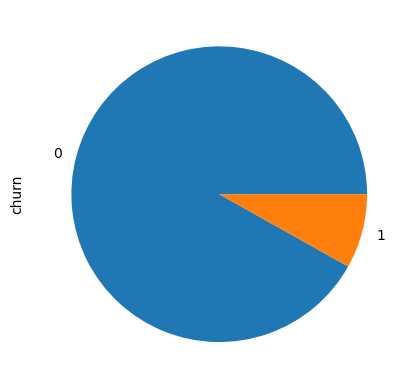

In [42]:
# lets find out churn/non churn percentage
print((df['churn'].value_counts()/len(df))*100)
((df['churn'].value_counts()/len(df))*100).plot(kind="pie")
plt.show()

As we can see that 91% of the customers do not churn, there is a possibility of class imbalance
Since this variable churn is the target variable, all the columns relating to this variable(i.e. all columns with suffix _9) can be dropped forn the dataset.

In [43]:
# Selecting all the churn phase columns in order to drop then

churn_phase_cols = [col for col in df.columns if '_9' in col]
print("The columns from churn phase are:\n",churn_phase_cols)

The columns from churn phase are:
 ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']


In [44]:
# Dropping the selected churn phase columns
df.drop(churn_phase_cols, axis=1, inplace=True)

# The curent dimension of the dataset after dropping the churn related columns
df.shape

(30001, 137)

We can still clean the data by few possible columns relating to the good phase.

As we derived few columns in the good phase earlier, we can drop those related columns during creation.

In [45]:
df.drop(['total_rech_data_6','av_rech_amt_data_6', 'total_rech_amt_6','total_rech_amt_7',\
         'total_rech_data_7','av_rech_amt_data_7'], axis=1, inplace=True)

Before proceding to check the remaining missing value handling, let us check the collineartity of the indepedent variables and try to understand their dependencies.

In [46]:
# creating a list of column names for each month
mon_6_cols = [col for col in df.columns if '_6' in col]
mon_7_cols = [col for col in df.columns if '_7' in col]
mon_8_cols = [col for col in df.columns if '_8' in col]

In [47]:
# lets check the correlation amongst the independent variables, drop the highly correlated ones
telecom_data_corr = df.corr()
telecom_data_corr.loc[:,:] = np.tril(telecom_data_corr, k=-1)
telecom_data_corr = telecom_data_corr.stack()
telecom_data_corr
telecom_data_corr[(telecom_data_corr > 0.80) | (telecom_data_corr < -0.80)].sort_values(ascending=False)

total_rech_amt_8    arpu_8              0.96
isd_og_mou_8        isd_og_mou_7        0.94
                    isd_og_mou_6        0.92
isd_og_mou_7        isd_og_mou_6        0.92
sachet_2g_8         total_rech_data_8   0.90
total_ic_mou_6      loc_ic_mou_6        0.90
total_ic_mou_8      loc_ic_mou_8        0.89
total_ic_mou_7      loc_ic_mou_7        0.88
std_og_t2t_mou_8    onnet_mou_8         0.86
std_og_t2t_mou_7    onnet_mou_7         0.86
std_og_t2t_mou_6    onnet_mou_6         0.86
std_og_t2m_mou_7    offnet_mou_7        0.85
std_og_t2m_mou_8    offnet_mou_8        0.85
total_og_mou_8      std_og_mou_8        0.85
total_og_mou_7      std_og_mou_7        0.85
loc_ic_mou_8        loc_ic_t2m_mou_8    0.85
std_ic_mou_8        std_ic_t2m_mou_8    0.85
loc_ic_mou_6        loc_ic_t2m_mou_6    0.84
loc_og_mou_8        loc_og_mou_7        0.84
loc_ic_mou_8        loc_ic_mou_7        0.84
loc_og_t2t_mou_8    loc_og_t2t_mou_7    0.83
loc_ic_mou_7        loc_ic_t2m_mou_7    0.83
total_og_m

dropping date columns as they are no use for the analysis

In [48]:
col_to_drop=['total_rech_amt_8','isd_og_mou_8','isd_og_mou_7','sachet_2g_8','total_ic_mou_6',\
             'total_ic_mou_8','total_ic_mou_7','std_og_t2t_mou_6','std_og_t2t_mou_8','std_og_t2t_mou_7',\
             'std_og_t2m_mou_7','std_og_t2m_mou_8']

# These columns can be dropped as they are highly collinered with other predictor variables.
# criteria set is for collinearity of 85%

#  dropping these column
df.drop(col_to_drop, axis=1, inplace=True)

In [49]:
# The curent dimension of the dataset after dropping few unwanted columns
df.shape

(30001, 119)

## Deriving new variables to understand the data and some EDA

In [50]:
# We have a column called 'aon'

# we can derive new variables from this to explain the data w.r.t churn.

# creating a new variable 'tenure'
df['tenure'] = (df['aon']/30).round(0)

# Since we derived a new column from 'aon', we can drop it
df.drop('aon',axis=1, inplace=True)

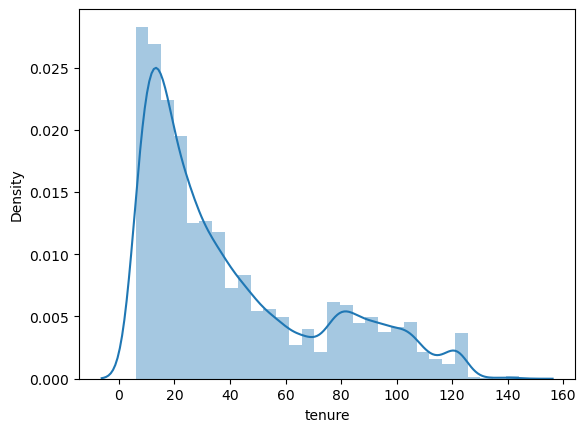

In [51]:
# Checking the distribution of he tenure variable

sns.distplot(df['tenure'],bins=30)
plt.show()

In [52]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
df['tenure_range'] = pd.cut(df['tenure'], tn_range, labels=tn_label)
df['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

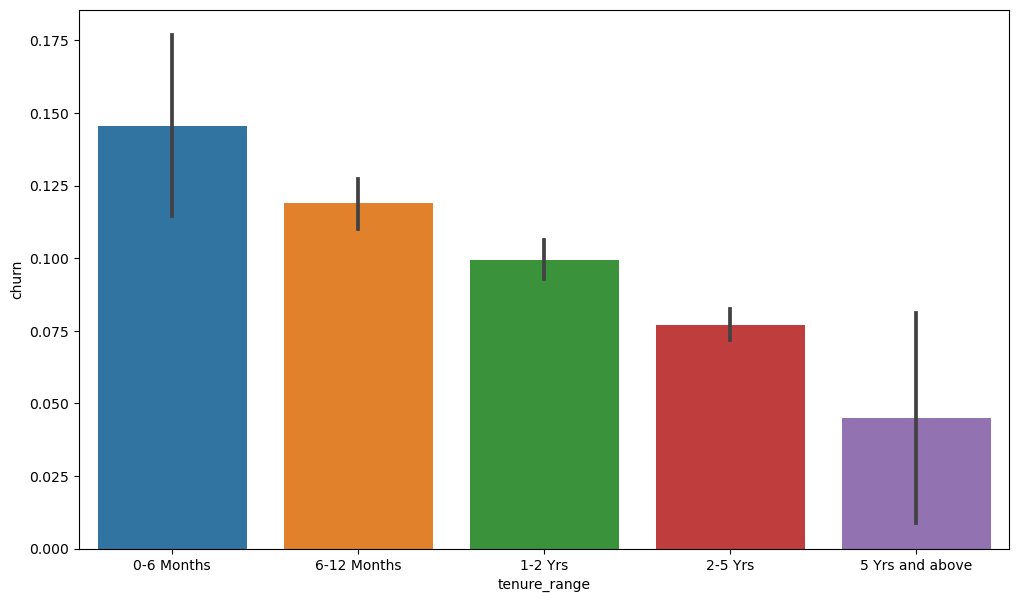

In [53]:
# Plotting a bar plot for tenure range
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn', data=df)
plt.show()

#### It can be seen that the maximum churn rate happens within 0-6 month, but it gradually decreases as the customer retains in the network.

The average revenue per user is good phase of customer is given by arpu_6 and arpu_7. since we have two seperate averages, lets take an average to these two and drop the other columns.

In [54]:
df["avg_arpu_6_7"]= (df['arpu_6']+df['arpu_7'])/2
df['avg_arpu_6_7'].head()


0     206.10
7    1209.51
8     435.47
21    556.10
23    134.12
Name: avg_arpu_6_7, dtype: float64

In [55]:
# Lets drop the original columns as they are derived to a new column for better understanding of the data

df.drop(['arpu_6','arpu_7'], axis=1, inplace=True)


# The curent dimension of the dataset after dropping few unwanted columns
df.shape

(30001, 119)

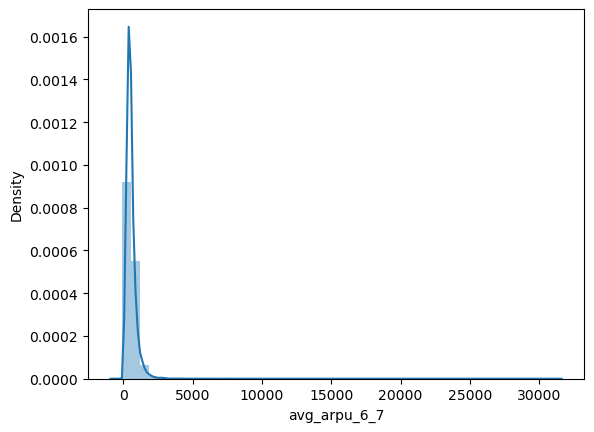

In [56]:
# Visualizing the column created
sns.distplot(df['avg_arpu_6_7'])
plt.show()

Text(0.5, 1.0, 'Features Correlating with Churn variable')

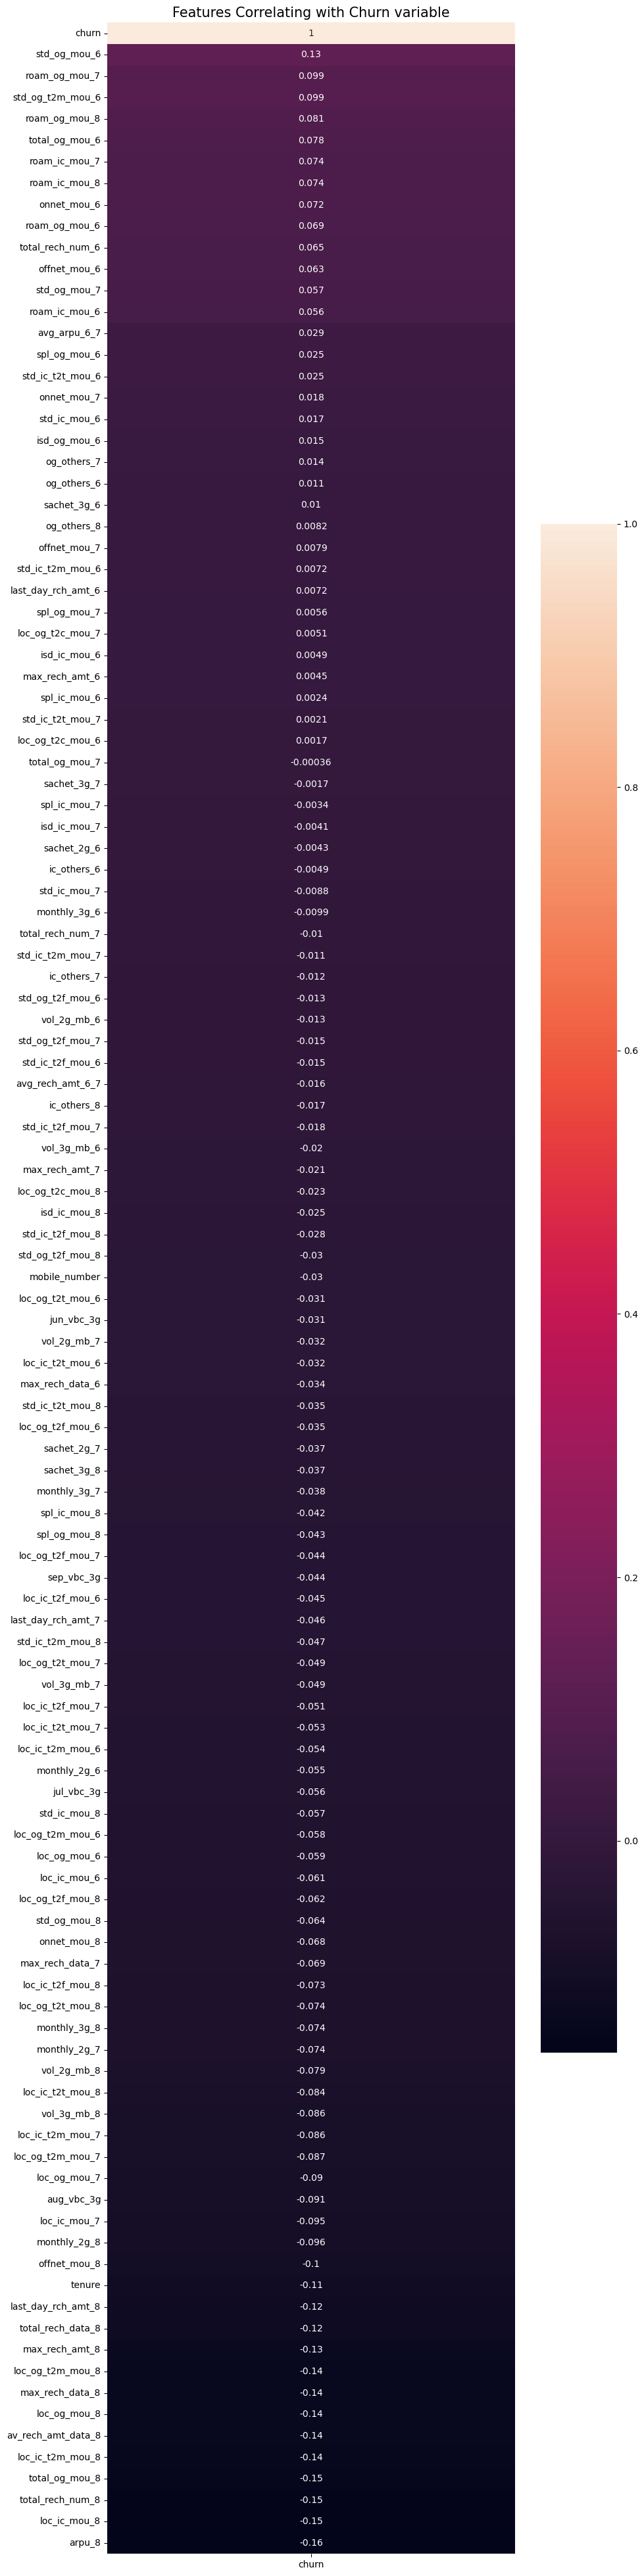

In [57]:
# Checking Correlation between target variable(SalePrice) with the other variable in the dataset
plt.figure(figsize=(10,50))
heatmap_churn = sns.heatmap(df.corr()[['churn']].sort_values(ascending=False, by='churn'),annot=True)
heatmap_churn.set_title("Features Correlating with Churn variable", fontsize=15)

Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn.
Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

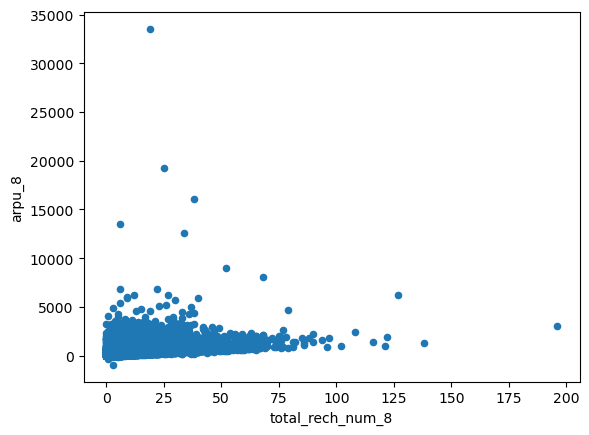

In [58]:
# lets now draw a scatter plot between total recharge and avg revenue for the 8th month
df[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')
plt.show()

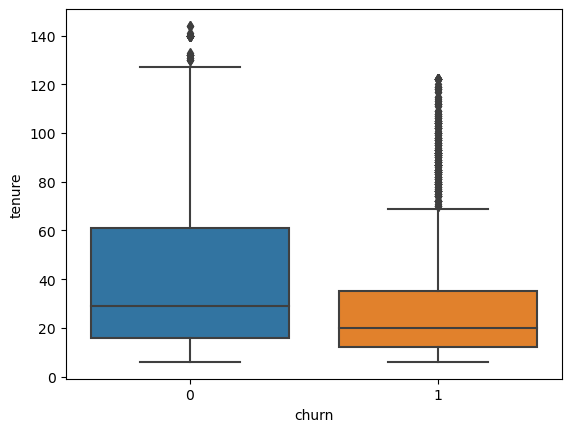

In [59]:
sns.boxplot(x = df.churn, y = df.tenure)

plt.show()

From the above plot , its clear tenured customers do no churn and they keep availing telecom services

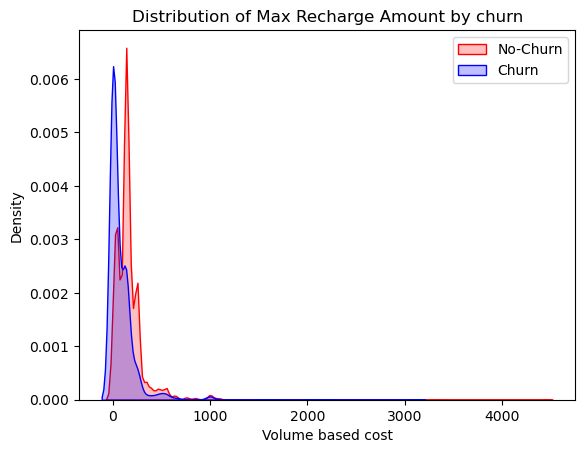

In [60]:
# Plot between churn vs max rechare amount
ax = sns.kdeplot(df.max_rech_amt_8[(df["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df.max_rech_amt_8[(df["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')
plt.show()

In [61]:
# Creating categories for month 8 column totalrecharge and their count
df['total_rech_num_group_8']=pd.cut(df['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])


					Distribution of total_rech_num_8 variable
 <=10_Recharges     19349
10-25_Recharges     8073
>25_Recharges       1996
No_Recharge          583
Name: total_rech_num_group_8, dtype: int64


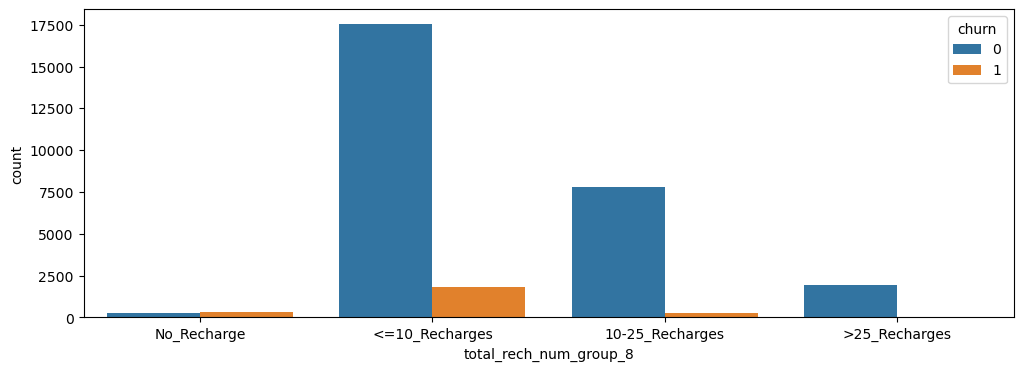

In [62]:
#plotting the results
plt.figure(figsize=[12,4])
sns.countplot(data=df,x="total_rech_num_group_8",hue="churn")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",df['total_rech_num_group_8'].value_counts())
plt.show()

In [63]:
df['total_rech_data_group_8']=pd.cut(df['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])


					Distribution of total_rech_data_group_8 variable
 <=10_Recharges     15307
No_Recharge        14048
10-25_Recharges      608
>25_Recharges         38
Name: total_rech_data_group_8, dtype: int64


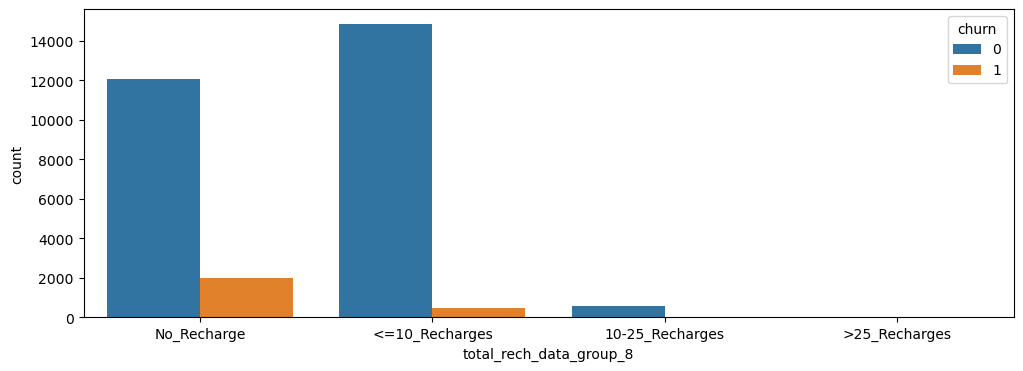

In [64]:
#plotting the results
plt.figure(figsize=[12,4])
sns.countplot(data=df,x="total_rech_data_group_8",hue="churn")
print("\t\t\t\t\tDistribution of total_rech_data_group_8 variable\n",df['total_rech_data_group_8'].value_counts())
plt.show()

As the number of recharge rate increases, the churn rate decreases clearly.

In [65]:
# create box plot for  6th, 7th and 8th month
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False)
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False)
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False)
    plt.show()

In [67]:
#Further seeing the churn wrt to the good phase and action phase based on recharge amount

recharge_amnt_columns =  df.columns[df.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_8',
 'avg_rech_amt_6_7']

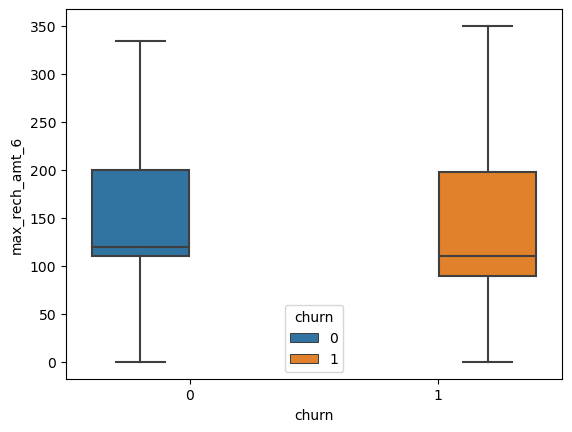

In [77]:
sns.boxplot(data=df, y='max_rech_amt_6',x="churn",hue="churn", showfliers=False)
plt.show()

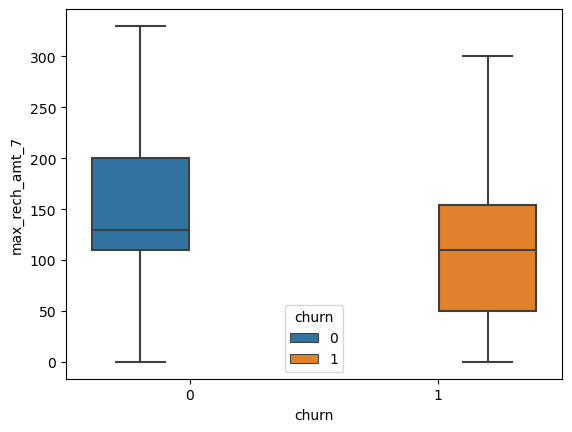

In [76]:
sns.boxplot(data=df, y='max_rech_amt_7',x="churn",hue="churn", showfliers=False)
plt.show()

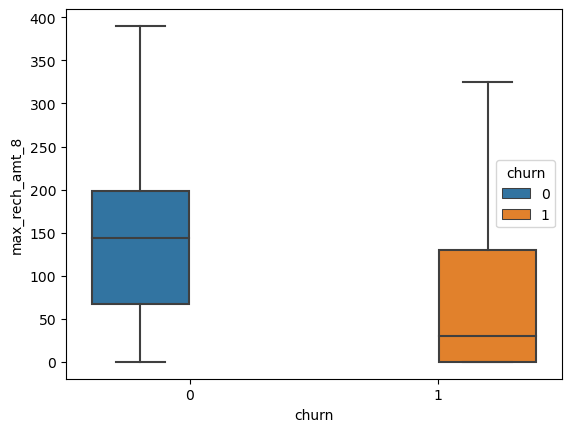

In [75]:
sns.boxplot(data=df, y='max_rech_amt_8',x="churn",hue="churn", showfliers=False)
plt.show()

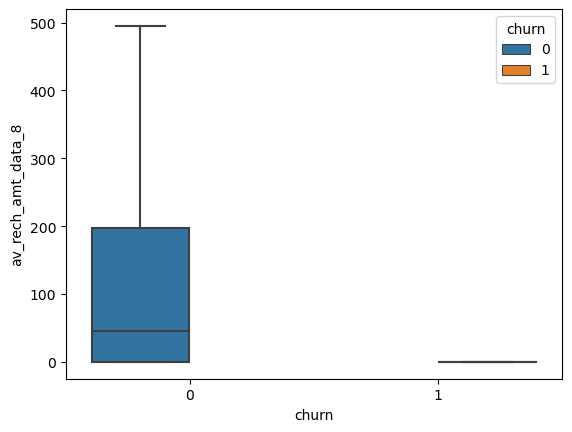

In [74]:
sns.boxplot(data=df, y='av_rech_amt_data_8',x="churn",hue="churn", showfliers=False)
plt.show()

From the above charts we can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

In [78]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(df[['total_rech_data_group_8','total_rech_num_group_8','tenure_range']], drop_first=True)
dummy.head()

,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,1,0,0,1,0,0,0,0,1,0
7,0,0,0,1,0,0,0,0,1,0
8,1,0,0,0,1,0,1,0,0,0
21,0,0,0,0,0,1,0,1,0,0
23,1,0,0,1,0,0,0,1,0,0


In [79]:
# Adding the results to the master dataframe
df = pd.concat([df, dummy], axis=1)
df.head()

,mobile_number,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7,churn,tenure,tenure_range,avg_arpu_6_7,total_rech_num_group_8,total_rech_data_group_8,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,7000842753.00,213.80,53.27,24.61,0.00,84.23,23.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,53.27,24.61,0.00,79.27,18.20,0.00,0.40,4.81,0.00,0.35,0.00,0.00,132.95,47.64,0.00,0.41,0.00,0.00,0.00,0.41,0.98,0.00,0.00,4.14,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,44.49,13.40,0.16,69.18,62.85,4.13,17.74,22.50,1.15,131.43,98.76,5.44,0.00,3.37,0.00,0.58,0.37,0.00,1.24,1.11,0.00,1.83,4.85,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.00,4.00,3.00,2.00,252.00,252.00,252.00,252.00,252.00,252.00,1.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,30.40,0.00,101.20,3.58,559.00,1,32.00,2-5 Yrs,206.10,<=10_Recharges,<=10_Recharges,1,0,0,1,0,0,0,0,1,0
7,7000701601.00,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,49.89,6.66,20.08,16.68,60.86,75.14,77.84,0.00,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5.00,5.00,7.00,1580.00,790.00,1580.00,0.00,0.00,779.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,57.74,19.38,18.74,0.00,1185.00,1,27.00,2-5 Yrs,1209.51,<=10_Recharges,No_Recharge,0,0,0,1,0,0,0,0,1,0
8,7001524846.00,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,13.69,0.00,0.00,0.00,130.26,143.48,98.28,0.00,0.00,0.00,10.23,0.00,0.00,0.00,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [80]:
# Dropping unwanted columns
df.drop(['tenure_range','mobile_number','total_rech_data_group_8','total_rech_num_group_8',\
         'sep_vbc_3g','tenure'], axis=1, inplace=True)


In [81]:
# Cheking the dataset
df.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_amt_6_7,churn,avg_arpu_6_7,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,213.80,53.27,24.61,0.00,84.23,23.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,53.27,24.61,0.00,79.27,18.20,0.00,0.40,4.81,0.00,0.35,0.00,0.00,132.95,47.64,0.00,0.41,0.00,0.00,0.00,0.41,0.98,0.00,0.00,4.14,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,44.49,13.40,0.16,69.18,62.85,4.13,17.74,22.50,1.15,131.43,98.76,5.44,0.00,3.37,0.00,0.58,0.37,0.00,1.24,1.11,0.00,1.83,4.85,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.00,4.00,3.00,2.00,252.00,252.00,252.00,252.00,252.00,252.00,1.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,30.40,0.00,101.20,559.00,1,206.10,1,0,0,1,0,0,0,0,1,0
7,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,49.89,6.66,20.08,16.68,60.86,75.14,77.84,0.00,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5.00,5.00,7.00,1580.00,790.00,1580.00,0.00,0.00,779.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,57.74,19.38,18.74,1185.00,1,1209.51,0,0,0,1,0,0,0,0,1,0
8,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,13.69,0.00,0.00,0.00,130.26,143.48,98.28,0.00,0.00,0.00,10.23,0.00,0.00,0.00,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.00,21.00,14.00,90.00,154.00,30.00,50.00,0.00,10.00,3.00,0.00,154.00,23.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,21.03,910.65,122.16,696.00,0,435.47,1,0,0,0,1

In [82]:
df.shape

(30001, 125)

Creating X and y

In [83]:
# lets create X dataset for model building.
X = df.drop(['churn'],axis=1)

In [84]:
# lets create y dataset for model building.
y=df['churn']

## Splitting the data 

In [85]:
# split the dateset into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (21000, 124)
Dimension of X_test: (9001, 124)


In [86]:
num_col = X_train.select_dtypes(include = ['int64','float64']).columns.tolist()
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])

## Data Imbalance Handling
Using SMOTE method, we can balance the data w.r.t. churn variable and proceed further

In [87]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [88]:

print("Dimension of X_train_sm Shape:", X_train_sm.shape)
print("Dimension of y_train_sm Shape:", y_train_sm.shape)

Dimension of X_train_sm Shape: (38576, 124)
Dimension of y_train_sm Shape: (38576,)


## Logistic Regression

In [89]:
# Importing necessary libraries for Model creation
import statsmodels.api as sm

In [90]:
# Logistic regression model
logm1 = sm.GLM(y_train_sm,(sm.add_constant(X_train_sm)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38451
Model Family:                Binomial   Df Model:                          124
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13883.
Date:                Tue, 08 Aug 2023   Deviance:                       27767.
Time:                        16:11:21   Pearson chi2:                 2.25e+14
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4865
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.0381      0.153      6.790      0.000       0.738       1.338
arpu_8                                      4.7072      1.726      2.728      0.006       1.325       8.090
onnet_mou_6                               -51.9107     28.741     -1.806      0.071    -108.243       4.421
onnet_mou_7                                60.3378     16.303      3.701      0.000      28.384      92.291
onnet_mou_8                               182.5140     24.102      7.573      0.000     135.275     229.753
offnet_mou_6                              -48.9722     32.406     -1.511      0.131    -112.487      14.542
offnet_mou_7                               74.0576     19.276      3.842      0.000      36.277     111.838
offnet_mou_8                              233.8357     31.360      7.457      0.000     172.372     295.300
roam_ic_mou_6                               2.9930      0.849      3.525      0.000       1.329       4.657
roam_ic_mou_7                               5.1827      1.573      3.294      0.001       2.099       8.267
roam_ic_mou_8                              -1.5860      0.802     -1.976      0.048      -3.159      -0.013
roam_og_mou_6                              22.2353     14.686      1.514      0.130      -6.549      51.020
roam_og_mou_7                             -12.7563      3.822     -3.337      0.001     -20.248      -5.265
roam_og_mou_8                             -56.1972      7.796     -7.208      0.000     -71.477     -40.917
loc_og_t2t_mou_6                        -6439.9329   1.98e+04     -0.326      0.745   -4.52e+04    3.23e+04
loc_og_t2t_mou_7                        -2.288e+04   2.28e+04     -1.003      0.316   -6.76e+04    2.18e+04
loc_og_t2t_mou_8                         1.906e+05   3.41e+04      5.589      0.000    1.24e+05    2.57e+05
loc_og_t2m_mou_6                        -4744.0909   1.45e+04     -0.326      0.744   -3.32e+04    2.37e+04
loc_og_t2m_mou_7                        -1.379e+04   1.37e+04     -1.004      0.315   -4.07e+04    1.31e+04
loc_og_t2m_mou_8                         6.287e+04   1.12e+04      5.590      0.000    4.08e+04    8.49e+04
loc_og_t2f_mou_6                         -676.0020   2078.804     -0.325      0.745   -4750.384    3398.380
loc_og_t2f_mou_7                        -3285.7778   3259.999     -1.008      0.313   -9675.258    3103.703
loc_og_t2f_mou_8                         1.646e+04   2944.296      5.591      0.000    1.07e+04    2.22e+04
loc_og_t2c_mou_6                           -4.9828      1.068     -4.666      0.000      -7.076      -2.890
loc_og_t2c_mou_7                            0.3830      1.874      0.204      0.838      -3.289       4.055
loc_og_t2c_mou_8                            0.2640      1.2

## Logistic Regression using Feature Selection (RFE method)

In [91]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE

# running RFE with 20 variables as output
rfe = RFE(logreg,  n_features_to_select=20)             
rfe = rfe.fit(X_train_sm, y_train_sm)

In [92]:
rfe.support_

array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False])

In [93]:
rfe_columns=X_train_sm.columns[rfe.support_]
print("The selected columns by RFE for modelling are: \n\n",rfe_columns)

The selected columns by RFE for modelling are: 

 Index(['arpu_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'std_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_8', 'std_ic_mou_8',
       'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8',
       'monthly_2g_8', 'aug_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [94]:
list(zip(X_train_sm.columns, rfe.support_, rfe.ranking_))

[('arpu_8', True, 1),
 ('onnet_mou_6', False, 22),
 ('onnet_mou_7', False, 37),
 ('onnet_mou_8', False, 45),
 ('offnet_mou_6', False, 35),
 ('offnet_mou_7', False, 21),
 ('offnet_mou_8', False, 27),
 ('roam_ic_mou_6', False, 14),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 59),
 ('roam_og_mou_6', False, 66),
 ('roam_og_mou_7', False, 29),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 72),
 ('loc_og_t2t_mou_7', False, 94),
 ('loc_og_t2t_mou_8', False, 19),
 ('loc_og_t2m_mou_6', False, 73),
 ('loc_og_t2m_mou_7', False, 67),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 104),
 ('loc_og_t2f_mou_7', False, 5),
 ('loc_og_t2f_mou_8', False, 24),
 ('loc_og_t2c_mou_6', False, 7),
 ('loc_og_t2c_mou_7', False, 65),
 ('loc_og_t2c_mou_8', False, 103),
 ('loc_og_mou_6', False, 47),
 ('loc_og_mou_7', False, 101),
 ('loc_og_mou_8', False, 2),
 ('std_og_t2m_mou_6', False, 97),
 ('std_og_t2f_mou_6', False, 71),
 ('std_og_t2f_mou_7', False, 28),
 ('std_og_t2f_mou_8',

## Assessing the model with StatsModels


In [95]:
X_train_SM = sm.add_constant(X_train_sm[rfe_columns])
logm2 = sm.GLM(y_train_sm,X_train_SM, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38555
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15836.
Date:                Tue, 08 Aug 2023   Deviance:                       31671.
Time:                        16:12:13   Pearson chi2:                 6.54e+10
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4318
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5576      0.070      7.944      0.000       0.420       0.695
arpu_8                -7.0858      1.284     -5.516      0.000      -9.603      -4.568
roam_ic_mou_7          8.3280      0.930      8.953      0.000       6.505      10.151
roam_og_mou_8          4.2491      0.600      7.082      0.000       3.073       5.425
loc_og_t2m_mou_8      -3.8072      0.668     -5.698      0.000      -5.117      -2.498
std_og_mou_7           7.7817      0.513     15.156      0.000       6.775       8.788
total_og_mou_8       -20.4011      0.956    -21.349      0.000     -22.274     -18.528
loc_ic_t2t_mou_8       1.7290      4.111      0.421      0.674      -6.329       9.787
loc_ic_t2m_mou_8      -0.7810      4.489     -0.174      0.862      -9.580       8.018
loc_ic_mou_6           9.3498      0.727     12.857      0.000       7.925      10.775
loc_ic_mou_8         -31.9202      5.061     -6.307      0.000     -41.840     -22.001
std_ic_mou_8         -11.9302      1.359     -8.777      0.000     -14.594      -9.266
spl_ic_mou_8         -19.6468      1.371    -14.334      0.000     -22.333     -16.960
total_rech_num_8      -7.1469      0.533    -13.406      0.000      -8.192      -6.102
last_day_rch_amt_8   -18.4172      0.811    -22.722      0.000     -20.006     -16.829
total_rech_data_8     -8.9252      0.612    -14.581      0.000     -10.125      -7.725
av_rech_amt_data_8    -5.2304      0.643     -8.135      0.000      -6.490      -3.970
vol_2g_mb_8          -10.5012      0.934    -11.243      0.000     -12.332      -8.670
monthly_2g_8          -5.7646      0.360    -16.015      0.000      -6.470      -5.059
aug_vbc_3g            -6.9176      0.590    -11.718      0.000      -8.075      -5.761
avg_arpu_6_7          18.3107      1.088     16.829      0.000      16.178      20.443
======================================================================================
"""

In [96]:
# From the p-value of the individual columns, 
#we can drop the column 'loc_ic_t2t_mou_8' as it has high p-value of 0.80
rfe_columns_1=rfe_columns.drop('loc_ic_t2t_mou_8',1)
print("\nThe new set of edited featured are:\n",rfe_columns_1)


The new set of edited featured are:
 Index(['arpu_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'std_og_mou_7', 'total_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'monthly_2g_8', 'aug_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [97]:
# Training the model with the edited feature list
X_train_SM = sm.add_constant(X_train_sm[rfe_columns_1])
logm2 = sm.GLM(y_train_sm,X_train_SM, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38556
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15836.
Date:                Tue, 08 Aug 2023   Deviance:                       31671.
Time:                        16:12:14   Pearson chi2:                 6.60e+10
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4318
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5568      0.070      7.934      0.000       0.419       0.694
arpu_8                -7.0864      1.285     -5.517      0.000      -9.604      -4.569
roam_ic_mou_7          8.3323      0.930      8.955      0.000       6.509      10.156
roam_og_mou_8          4.2511      0.600      7.084      0.000       3.075       5.427
loc_og_t2m_mou_8      -3.8100      0.668     -5.703      0.000      -5.119      -2.501
std_og_mou_7           7.7759      0.513     15.151      0.000       6.770       8.782
total_og_mou_8       -20.3896      0.955    -21.346      0.000     -22.262     -18.518
loc_ic_t2m_mou_8      -2.4368      2.139     -1.139      0.255      -6.628       1.755
loc_ic_mou_6           9.3547      0.727     12.862      0.000       7.929      10.780
loc_ic_mou_8         -29.9591      1.935    -15.479      0.000     -33.753     -26.166
std_ic_mou_8         -11.9417      1.359     -8.785      0.000     -14.606      -9.277
spl_ic_mou_8         -19.6418      1.371    -14.332      0.000     -22.328     -16.956
total_rech_num_8      -7.1369      0.533    -13.402      0.000      -8.181      -6.093
last_day_rch_amt_8   -18.4255      0.810    -22.739      0.000     -20.014     -16.837
total_rech_data_8     -8.9278      0.612    -14.586      0.000     -10.127      -7.728
av_rech_amt_data_8    -5.2363      0.643     -8.147      0.000      -6.496      -3.977
vol_2g_mb_8          -10.5001      0.934    -11.241      0.000     -12.331      -8.669
monthly_2g_8          -5.7657      0.360    -16.019      0.000      -6.471      -5.060
aug_vbc_3g            -6.9239      0.590    -11.732      0.000      -8.081      -5.767
avg_arpu_6_7          18.3214      1.088     16.843      0.000      16.189      20.453
======================================================================================
"""

In [98]:
# From the p-value of the individual columns, 
# we can drop the column 'loc_ic_t2m_mou_8' as it has high p-value of 0.7+
rfe_columns_2=rfe_columns_1.drop(['loc_ic_t2m_mou_8'],1)
print("\nThe new set of edited featured are:\n",rfe_columns_2)


The new set of edited featured are:
 Index(['arpu_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'std_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_8',
       'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'monthly_2g_8', 'aug_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [99]:
# Training the model with the edited feature list
X_train_SM = sm.add_constant(X_train_sm[rfe_columns_2])
logm2 = sm.GLM(y_train_sm,X_train_SM, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38557
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15836.
Date:                Tue, 08 Aug 2023   Deviance:                       31673.
Time:                        16:12:15   Pearson chi2:                 6.62e+10
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4318
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5532      0.070      7.887      0.000       0.416       0.691
arpu_8                -7.0488      1.284     -5.491      0.000      -9.565      -4.533
roam_ic_mou_7          8.3040      0.931      8.921      0.000       6.480      10.128
roam_og_mou_8          4.2614      0.600      7.101      0.000       3.085       5.438
loc_og_t2m_mou_8      -3.9926      0.650     -6.146      0.000      -5.266      -2.719
std_og_mou_7           7.7344      0.512     15.114      0.000       6.731       8.737
total_og_mou_8       -20.3080      0.952    -21.334      0.000     -22.174     -18.442
loc_ic_mou_6           9.3506      0.728     12.843      0.000       7.924      10.778
loc_ic_mou_8         -31.8133      1.072    -29.680      0.000     -33.914     -29.713
std_ic_mou_8         -11.9417      1.359     -8.786      0.000     -14.606      -9.278
spl_ic_mou_8         -19.6466      1.370    -14.338      0.000     -22.332     -16.961
total_rech_num_8      -7.1701      0.532    -13.484      0.000      -8.212      -6.128
last_day_rch_amt_8   -18.4301      0.810    -22.740      0.000     -20.019     -16.842
total_rech_data_8     -8.9245      0.612    -14.582      0.000     -10.124      -7.725
av_rech_amt_data_8    -5.2372      0.643     -8.148      0.000      -6.497      -3.977
vol_2g_mb_8          -10.5142      0.934    -11.257      0.000     -12.345      -8.684
monthly_2g_8          -5.7563      0.360    -15.998      0.000      -6.462      -5.051
aug_vbc_3g            -6.9292      0.590    -11.742      0.000      -8.086      -5.773
avg_arpu_6_7          18.3644      1.088     16.882      0.000      16.232      20.496
======================================================================================
"""

In [100]:
# Getting the predicted values on the train set
y_train_sm_pred = res.predict(X_train_SM)
y_train_sm_pred = y_train_sm_pred.values.reshape(-1)
y_train_sm_pred[:10]

array([1.38031697e-01, 4.01412731e-01, 3.22696028e-01, 4.14374398e-01,
       5.07320153e-01, 4.30048736e-01, 2.03758870e-05, 2.27654724e-01,
       5.17388067e-02, 7.08628685e-01])

## Creating a dataframe with the actual churn flag and the predicted probabilities

In [101]:
y_train_sm_pred_final = pd.DataFrame({'Converted':y_train_sm.values, 'Converted_prob':y_train_sm_pred})
y_train_sm_pred_final.head()

,Converted,Converted_prob
0,0,0.14
1,0,0.40
2,0,0.32
3,0,0.41
4,0,0.51


## Creating new column 'churn_pred' with 1 if Churn_Prob > 0.5 else 0


In [102]:
y_train_sm_pred_final['churn_pred'] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Viewing the prediction results
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred
0,0,0.14,0
1,0,0.40,0
2,0,0.32,0
3,0,0.41,0
4,0,0.51,1


In [103]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred )
print(confusion)

[[15670  3618]
 [ 2777 16511]]


In [104]:
# Checking the overall accuracy.
print("The overall accuracy of the model is:",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred))

The overall accuracy of the model is: 0.8342233513065118


In [105]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [106]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfe_columns_2].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfe_columns].values, i) for i in range(X_train_sm[rfe_columns_2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,spl_ic_mou_8,83.96
7,loc_ic_mou_8,42.88
0,arpu_8,18.89
6,loc_ic_mou_6,18.70
5,total_og_mou_8,5.45
12,total_rech_data_8,3.58
4,std_og_mou_7,3.27
8,std_ic_mou_8,2.88
15,monthly_2g_8,2.76
3,loc_og_t2m_mou_8,2.54


## Metrics beyond simply accuracy

In [107]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [108]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity = ",TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP/ float(TN+FP))

# positive predictive value 
print ("Precision = ",TP / float(TP+FP))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN / float(TN+ FN))

Sensitivity =  0.8560244711737868
Specificity =  0.8124222314392369
False Positive Rate =  0.18757776856076316
Precision =  0.8202593273386656
True Negative Prediction Rate =  0.8494606169024773


## Plotting the ROC Curve

In [109]:
# Defining a function to plot the roc curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Prediction Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [110]:
# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve( y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob, drop_intermediate = False )


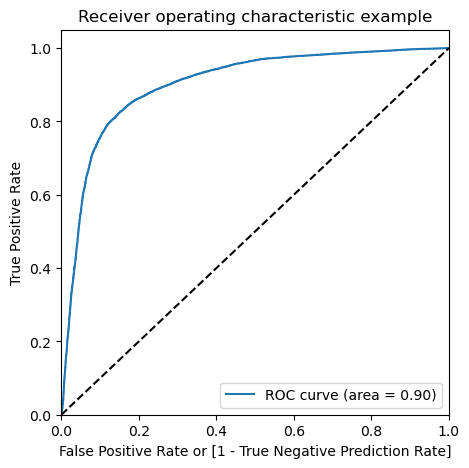

In [111]:
# Plotting the curve for the obtained metrics
draw_roc(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

## Finding Optimal Cutoff Point

In [112]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.14,0,1,1,0,0,0,0,0,0,0,0
1,0,0.40,0,1,1,1,1,1,0,0,0,0,0
2,0,0.32,0,1,1,1,1,0,0,0,0,0,0
3,0,0.41,0,1,1,1,1,1,0,0,0,0,0
4,0,0.51,1,1,1,1,1,1,1,0,0,0,0


In [113]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      probability  accuracy  sensitivity  specificity
0.00         0.00      0.50         1.00         0.00
0.10         0.10      0.69         0.98         0.40
0.20         0.20      0.75         0.96         0.55
0.30         0.30      0.79         0.93         0.66
0.40         0.40      0.82         0.89         0.74
0.50         0.50      0.83         0.86         0.81
0.60         0.60      0.84         0.81         0.87
0.70         0.70      0.82         0.73         0.91
0.80         0.80      0.76         0.56         0.95
0.90         0.90      0.61         0.25         0.98


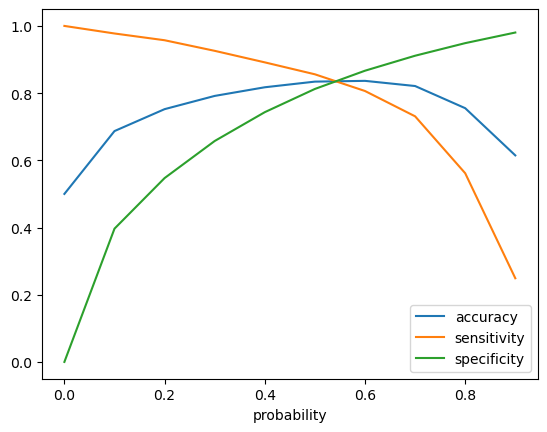

In [114]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

Initially we selected the optimm point of classification as 0.5.

From the above graph, we can see the optimum cutoff is slightly higher than 0.5 but lies lower than 0.6. So lets tweek a little more within this range.

In [115]:
# Let's create columns with refined probability cutoffs 
numbers = [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
0,0,0.14,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.40,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.32,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.41,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.51,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [116]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      probability  accuracy  sensitivity  specificity
0.50         0.50      0.83         0.86         0.81
0.51         0.51      0.84         0.85         0.82
0.52         0.52      0.84         0.85         0.83
0.53         0.53      0.84         0.84         0.83
0.54         0.54      0.84         0.84         0.84
0.55         0.55      0.84         0.83         0.84
0.56         0.56      0.84         0.83         0.85
0.57         0.57      0.84         0.82         0.85
0.58         0.58      0.84         0.82         0.86
0.59         0.59      0.84         0.81         0.86


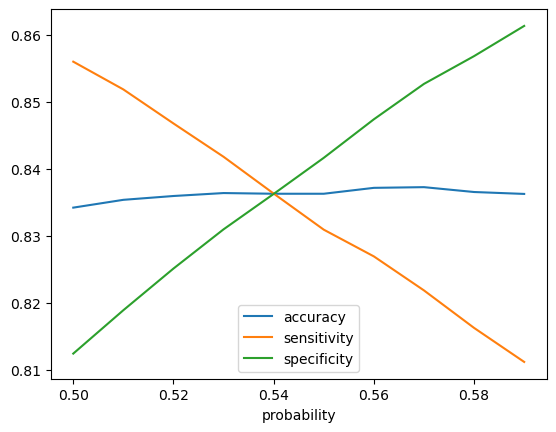

In [117]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

From the above graph we can conclude, the optimal cutoff point in the probability to define the predicted churn variabe converges at 0.54

In [118]:
# From the curve above, 0.2 is the optimum point to take it as a cutoff probability.

y_train_sm_pred_final['final_churn_pred'] = y_train_sm_pred_final.Converted_prob.map( lambda x: 1 if x > 0.54 else 0)

y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,final_churn_pred
0,0,0.14,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.40,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.32,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.41,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.51,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
# Calculating the ovearall accuracy again
print("The overall accuracy of the model now is:",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred))

The overall accuracy of the model now is: 0.8362971795935297


In [120]:
confusion2 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred )
print(confusion2)

[[16130  3158]
 [ 3157 16131]]


In [121]:
TP2 = confusion2[1,1] # true positive 
TN2 = confusion2[0,0] # true negatives
FP2 = confusion2[0,1] # false positives
FN2 = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP2 / float(TP2+FN2))

# Let us calculate specificity
print("Specificity = ",TN2 / float(TN2+FP2))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP2/ float(TN2+FP2))

# positive predictive value 
print ("Precision = ",TP2 / float(TP2+FP2))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN2 / float(TN2 + FN2))

Sensitivity =  0.8363231024471174
Specificity =  0.836271256739942
False Positive Rate =  0.16372874326005807
Precision =  0.8362797449323449
True Negative Prediction Rate =  0.8363146160626329


## Precision and recall tradeoff

In [122]:
from sklearn.metrics import precision_recall_curve

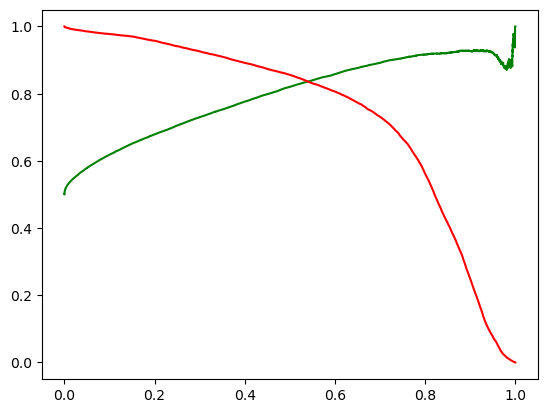

In [123]:
p, r, thresholds = precision_recall_curve(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

# Plotting the curve
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

## Making predictions on the test set

In [124]:
# Scaling the test data
X_test[num_col] = scaler.transform(X_test[num_col])
X_test.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_amt_6_7,avg_arpu_6_7,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
35865,0.03,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.05,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0,0,0,1,0,0,1,0,0,0
41952,0.05,0.01,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.01,0.02,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.03,0.05,0.02,0.00,0.01,0.01,0.00,0.00,0.00,0.02,0.05,0.02,0.00,0.01,0.01,0.02,0.04,0.00,0.00,0.00,0.00,0.02,0.03,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.04,0.02,0.05,0.04,0.03,0.05,0.02,0.01,0.02,0.10,0.09,0.09,0.04,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.07,0.06,0.03,0.00,0.00,0.02,0.06,0.00,0.00,0.08,1,0,0,1,0,0,0,0,1,0
98938,0.06,0.00,0.04,0.01,0.01,0.03,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.02,0.05,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.05,0.02,0.02,0.03,0.05,0.06,0.24,0.18,0.02,0.00,0.00,0.06,0.18,0.18,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.08,0.04,0.06,0.06,0.06,0.06,0.01,0.03,0.04,0.16,0.16,0.16,0.12,0.01,0.03,0.06,0.04,0.03,0.05,0.00,0.00,0.00,0.00,0.00,0.14,0.07,0.12,0.00,0.00,0.00,0.21,0.09,0.07,0.02,0.10,1,0,0,1,0,0,0,0,0,0
29459,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.01,0.02,0.00,0.00,0.02,0.00,

In [125]:
# Feature selection
X_test=X_test[rfe_columns_2]
X_test.head()

,arpu_8,roam_ic_mou_7,roam_og_mou_8,loc_og_t2m_mou_8,std_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_8,std_ic_mou_8,spl_ic_mou_8,total_rech_num_8,last_day_rch_amt_8,total_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,monthly_2g_8,aug_vbc_3g,avg_arpu_6_7
35865,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.06
41952,0.05,0.00,0.00,0.01,0.02,0.01,0.02,0.02,0.01,0.00,0.02,0.01,0.02,0.04,0.00,0.00,0.02,0.08
98938,0.06,0.00,0.00,0.07,0.00,0.02,0.06,0.18,0.00,0.00,0.04,0.03,0.04,0.12,0.06,0.00,0.21,0.10
29459,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.03,0.05,0.06,0.01,0.20,0.07,0.07
70682,0.10,0.00,0.03,0.04,0.17,0.16,0.02,0.07,0.00,0.08,0.06,0.03,0.02,0.01,0.00,0.00,0.00,0.10


In [126]:
# Adding constant to the test model.
X_test_SM = sm.add_constant(X_test)

In [127]:
# Predicting the target variable
y_test_pred = res.predict(X_test_SM)
print("\n The first ten probability value of the prediction are:\n",y_test_pred[:10])


 The first ten probability value of the prediction are:
 35865   0.77
41952   0.52
98938   0.00
29459   0.13
70682   0.01
58317   0.24
4860    0.01
16890   0.70
61329   0.65
94332   0.49
dtype: float64


In [128]:
y_pred = pd.DataFrame(y_test_pred)
y_pred.head()

,0
35865,0.77
41952,0.52
98938,0.00
29459,0.13
70682,0.01


In [129]:
y_pred=y_pred.rename(columns = {0:"Conv_prob"})

In [130]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
35865,0
41952,0
98938,0
29459,0
70682,0


In [131]:
y_pred_final = pd.concat([y_test_df,y_pred],axis=1)
y_pred_final.head()

,churn,Conv_prob
35865,0,0.77
41952,0,0.52
98938,0,0.00
29459,0,0.13
70682,0,0.01


In [132]:
y_pred_final['test_churn_pred'] = y_pred_final.Conv_prob.map(lambda x: 1 if x>0.54 else 0)
y_pred_final.head()

,churn,Conv_prob,test_churn_pred
35865,0,0.77,1
41952,0,0.52,0
98938,0,0.00,0
29459,0,0.13,0
70682,0,0.01,0


In [133]:
# Checking the overall accuracy of the predicted set.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred)

0.8271303188534608

In [134]:
# Confusion Matrix
confusion2_test = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.test_churn_pred)
print("Confusion Matrix\n",confusion2_test)

Confusion Matrix
 [[6861 1411]
 [ 145  584]]


In [135]:
TP3 = confusion2_test[1,1] # true positive 
TN3 = confusion2_test[0,0] # true negatives
FP3 = confusion2_test[0,1] # false positives
FN3 = confusion2_test[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP3 / float(TP3+FN3))

# Let us calculate specificity
print("Specificity = ",TN3 / float(TN3+FP3))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP3/ float(TN3+FP3))

# positive predictive value 
print ("Precision = ",TP3 / float(TP3+FP3))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN3 / float(TN3 + FN3))

Sensitivity =  0.8010973936899863
Specificity =  0.8294245647969052
False Positive Rate =  0.1705754352030948
Precision =  0.29273182957393484
True Negative Prediction Rate =  0.9793034541821296


The accuracy of the predicted model is:  83.0 %
The sensitivity of the predicted model is:  80.0 %

As the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer

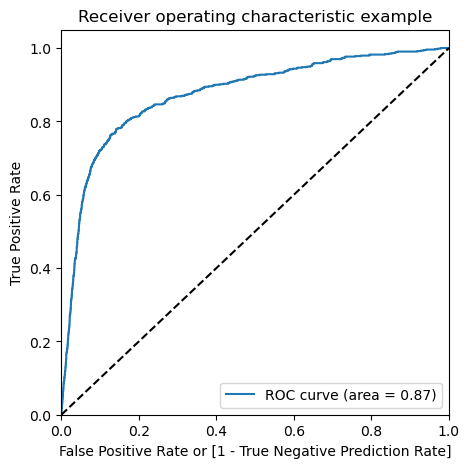

In [136]:
# ROC curve for the test dataset

# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve(y_pred_final.churn,y_pred_final.Conv_prob, drop_intermediate = False )
# Plotting the curve for the obtained metrics
draw_roc(y_pred_final.churn,y_pred_final.Conv_prob)

The AUC score for train dataset is 0.90 and the test dataset is 0.87.
This model can be considered as a good model.

## PCA

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

In [138]:
# PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to correct class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = "minority")
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 124)
(38576,)


In [139]:
# import PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

# apply PCA on train data
pca.fit(X_tr)

PCA(random_state=100)

In [140]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(38576, 124)
(9001, 124)


In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# make the predictions
y_pred = lr_pca.predict(X_test_pca)

# convert prediction array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test,y_pred))

[[6855 1417]
 [ 131  598]]
Accuracy of the logistic regression model with PCA:  0.8280191089878902


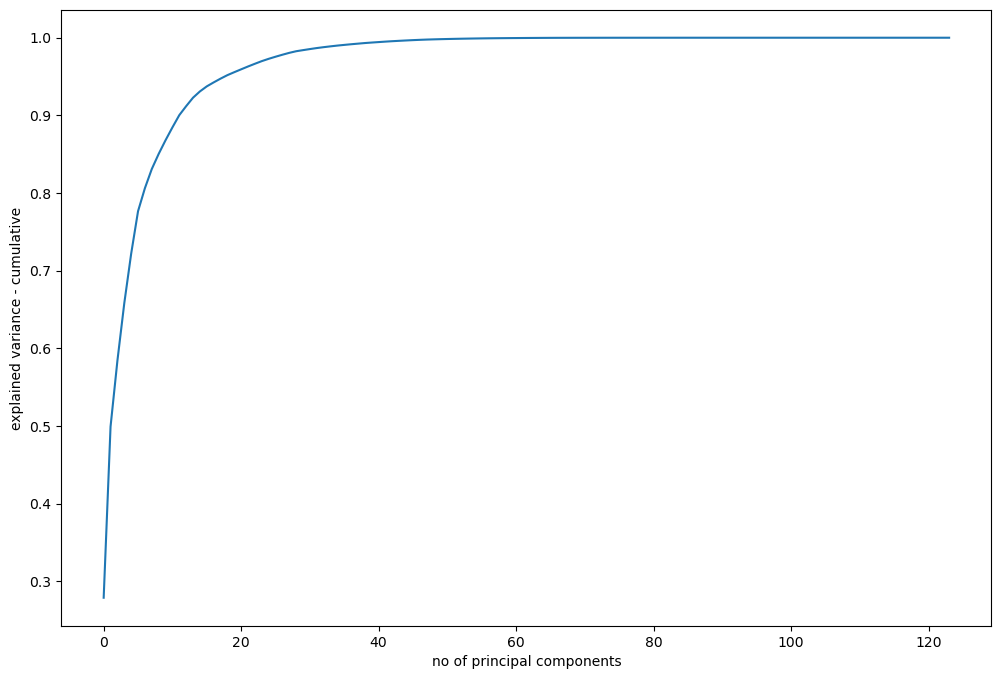

In [143]:
# scree plot to check the variance explained by different PCAs
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of principal components')
plt.ylabel('explained variance - cumulative')
plt.show()

In [145]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
# 12 columns explains 95% of the variance, lets apply PCA with 12 components

array([ 27.88,  49.92,  58.43,  65.83,  72.2 ,  77.67,  80.64,  83.1 ,
        85.04,  86.8 ,  88.45,  90.03,  91.19,  92.28,  93.09,  93.74,
        94.25,  94.73,  95.18,  95.56,  95.93,  96.3 ,  96.65,  96.99,
        97.29,  97.56,  97.82,  98.06,  98.27,  98.41,  98.55,  98.68,
        98.79,  98.89,  98.99,  99.08,  99.16,  99.24,  99.32,  99.38,
        99.44,  99.5 ,  99.56,  99.61,  99.66,  99.7 ,  99.74,  99.77,
        99.8 ,  99.82,  99.84,  99.86,  99.88,  99.9 ,  99.91,  99.92,
        99.93,  99.94,  99.95,  99.96,  99.97,  99.98,  99.99, 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
      

From above we can say 12 components are optimal

In [146]:
# PCA with 33 components
pca_12 = PCA(n_components=12)

df_tr_pca_12 = pca_12.fit_transform(X_tr)
print(df_tr_pca_12.shape)

df_test_pca_12 = pca_12.transform(X_test)
print(df_test_pca_12.shape)

(38576, 12)
(9001, 12)


In [148]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_12, y_tr)

# Predicted probabilities
y_pred12 = lr_pca1.predict(df_test_pca_12)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred12)

print("Accuracy with 12 PCAs: ",accuracy_score(y_test,y_pred12))

Accuracy with 12 PCAs:  0.7663592934118432


In [149]:
confusion_pca_test = confusion_matrix(y_test,y_pred12)
print(confusion_pca_test)

[[6325 1947]
 [ 156  573]]


In [150]:
TP4 = confusion_pca_test[1,1] # true positive 
TN4 = confusion_pca_test[0,0] # true negatives
FP4 = confusion_pca_test[0,1] # false positives
FN4 = confusion_pca_test[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP4 / float(TP4+FN4))

# Let us calculate specificity
print("Specificity = ",TN4 / float(TN4+FP4))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP4/ float(TN4+FP4))

# positive predictive value 
print ("Precision = ",TP4 / float(TP4+FP4))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN4 / float(TN4 + FN4))

Sensitivity =  0.7860082304526749
Specificity =  0.7646276595744681
False Positive Rate =  0.23537234042553193
Precision =  0.22738095238095238
True Negative Prediction Rate =  0.9759296404875791


Conclusions from the above model:

Model has 76% Accuracy
12 features can explain 90% variance in the dataset

## Decision Tree

In [151]:
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = "minority")
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 124)
(38576,)


In [152]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

(38576, 84)
[  0   1   2   3   4   5   6   7   8  10  12  13  14  15  17  20  21  22
  24  25  26  27  29  30  31  32  33  34  35  36  37  42  43  44  47  48
  49  50  52  55  56  57  58  59  61  63  65  66  68  73  74  75  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  97 101
 102 107 109 110 112 113 114 117 118 120 121 122]


In [153]:
# feature vector for decision tree
lasso_features = list(df.columns[position])
print("Lasso Features: ", lasso_features)

Lasso Features:  ['arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_8', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'm

In [154]:
# import decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# lets create a decision tree with the default hyper parameters except max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [155]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8272
           1       0.39      0.65      0.49       729

    accuracy                           0.89      9001
   macro avg       0.68      0.78      0.71      9001
weighted avg       0.92      0.89      0.90      9001



In [156]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))

[[7524  748]
 [ 254  475]]
Decision Tree - Accuracy : 0.8886790356627041


## Lets fine tune hyperparameters

In [157]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [158]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.15,0.00,0.00,0.00,1,{'max_depth': 1},0.76,0.78,0.79,0.79,0.80,0.78,0.01,39,0.79,0.78,0.78,0.78,0.78,0.78,0.00
1,0.28,0.00,0.00,0.00,2,{'max_depth': 2},0.84,0.86,0.86,0.86,0.86,0.86,0.01,38,0.86,0.86,0.86,0.86,0.86,0.86,0.00
2,0.42,0.01,0.00,0.00,3,{'max_depth': 3},0.84,0.87,0.87,0.87,0.87,0.86,0.01,37,0.87,0.87,0.86,0.87,0.87,0.87,0.00
3,0.54,0.01,0.00,0.00,4,{'max_depth': 4},0.85,0.88,0.89,0.88,0.89,0.88,0.02,36,0.89,0.88,0.88,0.88,0.88,0.88,0.00
4,0.66,0.01,0.00,0.00,5,{'max_depth': 5},0.85,0.90,0.90,0.89,0.90,0.89,0.02,35,0.90,0.89,0.89,0.90,0.89,0.90,0.00


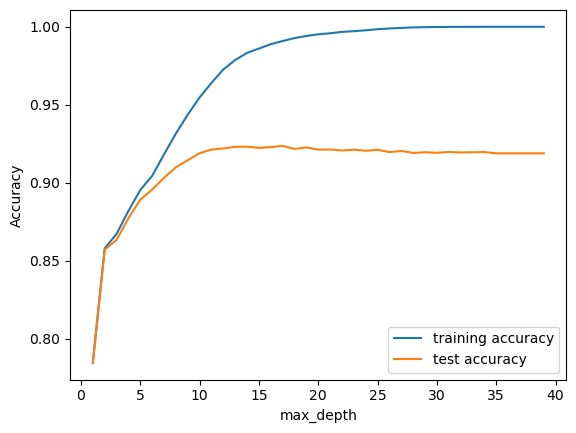

In [159]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# max_depth =10 seems to be the optimal one

In [160]:
# lets find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [161]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.02,0.04,0.00,0.00,5,{'min_samples_leaf': 5},0.86,0.93,0.93,0.93,0.93,0.92,0.03,1,0.98,0.97,0.97,0.97,0.97,0.97,0.00
1,1.68,0.04,0.00,0.00,25,{'min_samples_leaf': 25},0.86,0.92,0.92,0.92,0.92,0.91,0.02,2,0.94,0.93,0.93,0.93,0.93,0.93,0.00
2,1.53,0.03,0.00,0.00,45,{'min_samples_leaf': 45},0.86,0.91,0.92,0.91,0.92,0.90,0.02,3,0.93,0.92,0.92,0.92,0.92,0.92,0.00
3,1.48,0.02,0.00,0.00,65,{'min_samples_leaf': 65},0.86,0.90,0.91,0.91,0.92,0.90,0.02,4,0.92,0.91,0.91,0.91,0.91,0.91,0.00
4,1.37,0.03,0.00,0.00,85,{'min_samples_leaf': 85},0.86,0.90,0.91,0.90,0.91,0.89,0.02,5,0.91,0.90,0.91,0.91,0.90,0.91,0.00


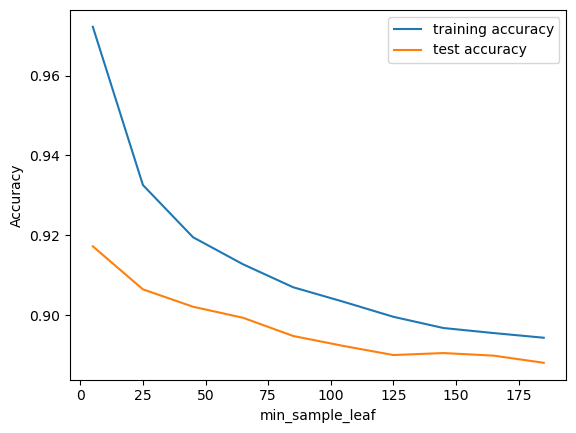

In [162]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_sample_leaf =25 seems to be the optimal one

In [163]:
# lets fine tune min sample split now
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [164]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.23,0.07,0.00,0.00,5,{'min_samples_split': 5},0.87,0.93,0.93,0.93,0.93,0.92,0.03,1,1.00,1.00,0.99,1.00,0.99,1.00,0.00
1,2.21,0.08,0.00,0.00,25,{'min_samples_split': 25},0.86,0.92,0.93,0.92,0.93,0.91,0.03,2,0.98,0.97,0.97,0.97,0.97,0.97,0.00
2,2.19,0.07,0.00,0.00,45,{'min_samples_split': 45},0.85,0.92,0.92,0.92,0.92,0.91,0.03,3,0.96,0.95,0.95,0.95,0.96,0.95,0.00
3,2.16,0.06,0.00,0.00,65,{'min_samples_split': 65},0.85,0.92,0.92,0.92,0.92,0.91,0.03,4,0.95,0.94,0.95,0.94,0.94,0.95,0.00
4,2.16,0.07,0.00,0.00,85,{'min_samples_split': 85},0.85,0.91,0.92,0.91,0.92,0.90,0.03,5,0.94,0.93,0.94,0.94,0.94,0.94,0.00


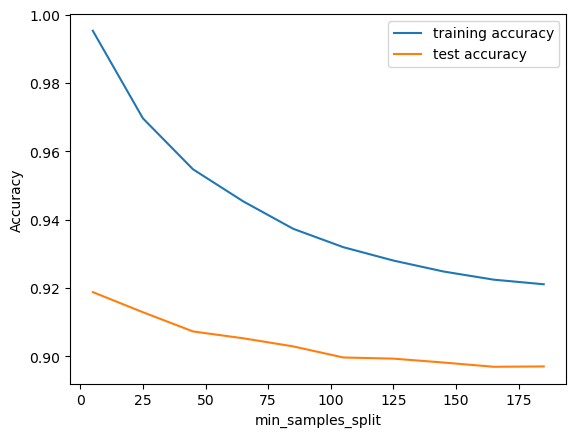

In [165]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_samples_leaf=50 seems to be optimal

In [166]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [167]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)

Best Accuracy 0.910981956003248


In [168]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=25,
                       min_samples_split=50)


In [169]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [170]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8846794800577713


89% accuracy on the test model

## XGBoost
Let's finally try XGBoost. The hyperparameters are the same, some important ones being subsample, learning_rate, max_depth etc.

In [171]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [172]:
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = "minority")
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 124)
(38576,)


In [185]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_tr.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_tr.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [180]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [186]:
# evaluate predictions
y_pred = model.predict(X_test)

In [198]:
import itertools
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score,accuracy_score,confusion_matrix

def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_model_metrics(y_test,y_pred,model_name):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df_cf = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])

    return df_cf 


 Model Stats Scores Summary : 


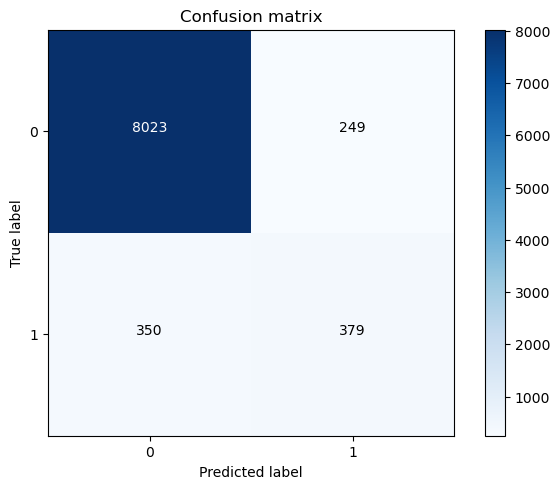

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Default),0.93,0.52,0.60,0.74,0.56


In [199]:
print_model_metrics(y_test, y_pred ,'XGBoost (Default)')

The roc_auc in this case is about 74% with default hyperparameters.

Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters

In [200]:
# hyperparameter tuning with XGBoost
# creating a KFold object 
folds = 5
# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          
# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)

In [201]:
# fit the model
model_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     m

In [202]:
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

In [203]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of **'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

We can get accuracy of **0.95** using {'learning_rate': 0.2, 'subsample': 0.5}


In [206]:
def plot_for_xboost(param_grid,cv_results):
    plt.figure(figsize=(18,5))
    for n, subsample in enumerate(param_grid['subsample']):
    # subplot 1/n
        plt.subplot(1,len(param_grid['subsample']), n+1)
        df = cv_results[cv_results['param_subsample']==subsample]
        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('AUC')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='lower right')
        plt.xscale('log')

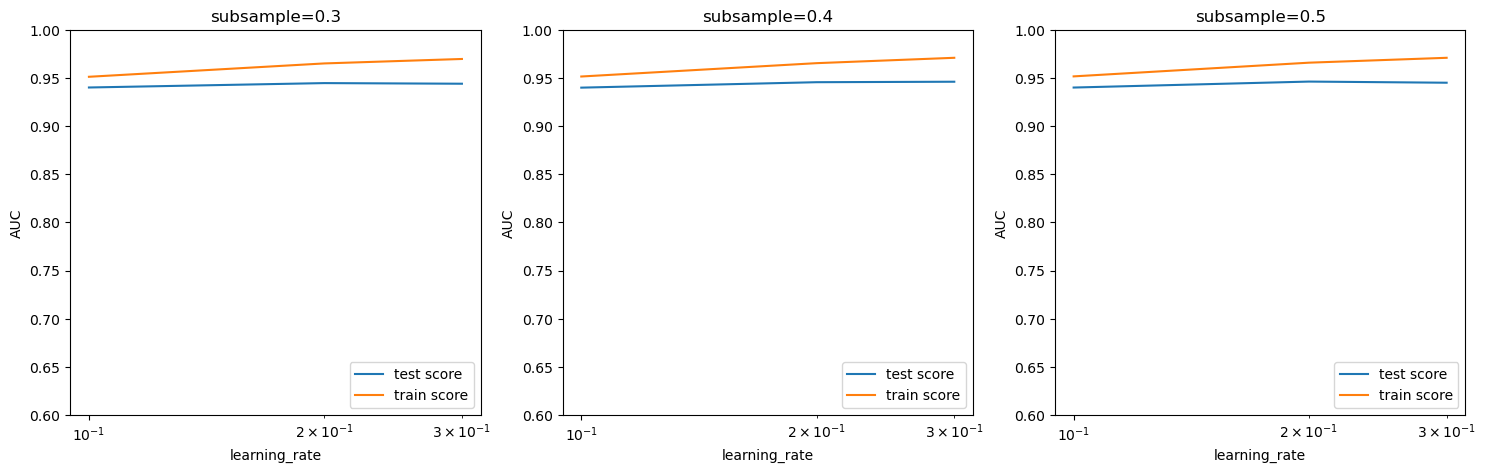

In [207]:
param_grid1 = {'learning_rate': [0.1,0.2,0.3], 'subsample': [0.3,0.4,0.5]}  
plot_for_xboost(param_grid1,cv_results_xboost)

Analysis: The results show that a subsample size of 0.3 and learning_rate of about 0.1 seems optimal. Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters).

Let's build a final model with the chosen hyperparameters.

In [209]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc

param = {'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.3,
         'objective':'binary:logistic'}


# fit model on training data

model = XGBClassifier(max_depth=2, n_estimators=200)
model.set_params(**param)
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [210]:
# evaluate predictions
y_pred = model.predict(X_test)

 Model Stats Scores Summary : 


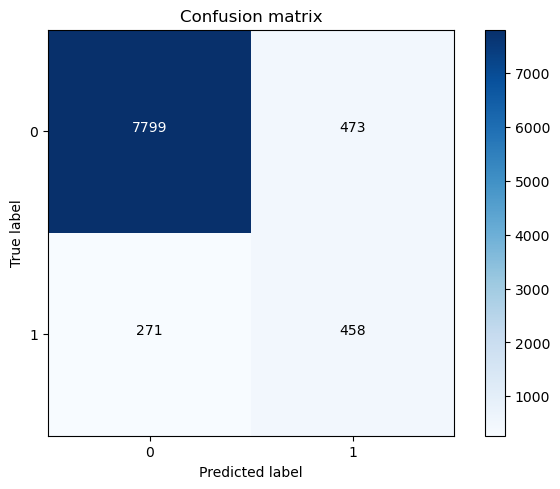

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Hyper Tuned),0.92,0.63,0.49,0.79,0.55


In [211]:
print_model_metrics(y_test, y_pred,'XGBoost (Hyper Tuned)')

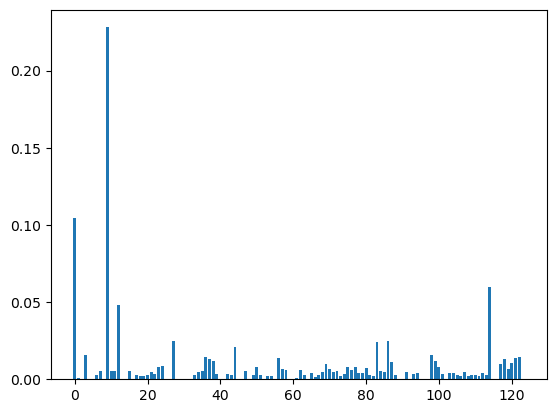

In [212]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [217]:
print("Important features ...")
plt.figure(figsize=(6,4))

col = list(X_tr.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

Important features ...


,PC1,PC2,PC3,Feature
0,-0.06,0.13,-0.26,arpu_8
1,-0.17,0.05,0.05,onnet_mou_6
2,-0.17,0.06,-0.12,onnet_mou_7
3,-0.11,0.05,-0.20,onnet_mou_8
4,-0.21,0.08,0.19,offnet_mou_6
5,-0.21,0.09,-0.04,offnet_mou_7
6,-0.12,0.07,-0.21,offnet_mou_8
7,0.00,-0.00,-0.00,roam_ic_mou_6
8,0.00,-0.00,0.00,roam_ic_mou_7
9,-0.00,0.00,0.00,roam_ic_mou_8


<Figure size 600x400 with 0 Axes>

## Recommendations
### Business Insights

Less number of high value customer are churing but for last 6 month no new high valued cusotmer is onboarded which is concerning and company should concentrate on that aspect.

Customers with less than 4 years of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group.

Average revenue per user seems to be most important feature in determining churn prediction.

Incoming and Outgoing Calls on romaing for 8th month are strong indicators of churn behaviour

Local Outgoing calls made to landline , fixedline , mobile and call center provides a strong indicator of churn behaviour.

Better 2G/3G area coverage where 2G/3G services are not good, it's strong indicator of churn behaviour.



## Model Insights

Logistic Regression with RFE produces an accuracy of 87%
Logistic Regression with PCA produces an accuracy of 76%
Decision Tree without Hyper Parameter Tuning produces an accuracy of 89%
Decision Tree with Hyper Parameter Tuning produces an accuracy of 89%
XGBoost without Hyper Parameter Tuning produces an accuracy of 93%
XGBoost with Hyper Parameter Tuning produces an accuracy of 92%

Thus making XGBoost with Hyper Parameter Tuning the best model as the default could be overfit